# Using Machine Learning to Distinguish Between Benign and Malignant Tumors

> *This project demonstrates how machine learning can be used to predict the severity of breast cancer tumors, utilizing a combination of feature engineering, model tuning, and performance evaluation to enhance diagnostic accuracy.*

In [12]:
# =============================================================================
# IMPORTS AND SETUP
# =============================================================================

# General imports for data manipulation and visualization
import pandas as pd  # Pandas is used for data manipulation and analysis, such as reading datasets and data wrangling.
import numpy as np  # Numpy provides support for arrays and matrices, along with mathematical functions for handling them.
import matplotlib.pyplot as plt  # Matplotlib is used for creating static, animated, and interactive visualizations in Python.
import seaborn as sns  # Seaborn is built on top of Matplotlib and provides a high-level interface for drawing attractive statistical graphics.
import warnings  # Warnings library to control the display of warnings in the output.
from pathlib import Path  # Path is part of the standard library and provides convenient methods for working with filesystem paths.
import joblib  # Joblib is used to save machine learning models (serialization), and is more efficient for large numpy arrays.
from datetime import datetime  # Used for working with dates and times in Python. Here it’s used to print the current time of the analysis.

# Machine Learning imports
from sklearn.model_selection import (
    train_test_split,  # Used to split the dataset into training and testing sets.
    GridSearchCV,  # A method to perform hyperparameter tuning by exhaustively searching through a specified parameter grid.
    cross_val_score,  # Performs cross-validation and computes scores for a given model.
    StratifiedKFold,  # A cross-validator that splits data into K folds while preserving the percentage of samples for each class.
    learning_curve,  # Used to plot learning curves to help visualize model performance across different sizes of training data.
    validation_curve  # Helps in determining the effect of varying model hyperparameters.
)

# Machine learning algorithms used for classification tasks
from sklearn.ensemble import (
    RandomForestClassifier,  # An ensemble method based on decision trees. It builds multiple trees and averages their predictions.
    GradientBoostingClassifier,  # A boosting method that combines weak learners (decision trees) to form a strong predictive model.
    VotingClassifier,  # An ensemble method that combines predictions from multiple classifiers by majority voting.
    AdaBoostClassifier  # Another boosting technique which adjusts the weights of weak learners to improve accuracy.
)

from sklearn.linear_model import LogisticRegression  # Logistic Regression is a linear model for binary classification tasks.
from sklearn.svm import SVC  # Support Vector Classifier is a supervised machine learning model for classification tasks.
from sklearn.preprocessing import StandardScaler, LabelEncoder  # Preprocessing tools for scaling data and encoding labels.
from sklearn.metrics import (
    classification_report,  # Provides a detailed performance report including precision, recall, f1-score, etc.
    confusion_matrix,  # Helps in evaluating classification results by providing a matrix of true vs predicted values.
    roc_auc_score,  # Computes the Area Under the ROC Curve (AUC), a measure of model’s ability to distinguish between classes.
    roc_curve,  # Computes the Receiver Operating Characteristic curve, a graphical representation of model performance.
    precision_recall_curve,  # A curve that illustrates the trade-off between precision and recall for different thresholds.
    f1_score,  # The harmonic mean of precision and recall. It’s used as a measure of model accuracy.
    accuracy_score,  # Measures the overall accuracy of the model by computing the ratio of correct predictions to total predictions.
    precision_score,  # Measures the precision of the model, i.e., how many of the predicted positive cases are actually positive.
    recall_score,  # Measures the recall of the model, i.e., how many of the actual positive cases were correctly identified.
    auc  # Computes the Area Under the Curve (AUC), typically used with the ROC curve to evaluate model performance.
)

from sklearn.feature_selection import SelectKBest, f_classif, RFE  # Feature selection techniques to identify the most relevant features.
from sklearn.decomposition import PCA  # Principal Component Analysis (PCA) is a technique for dimensionality reduction.
from sklearn.cluster import KMeans  # KMeans is an unsupervised learning algorithm used for clustering data into k groups.

# Advanced Analytics imports
import shap  # SHAP (SHapley Additive exPlanations) is a library for model interpretability and explaining machine learning predictions.
from scipy import stats  # SciPy provides functions for scientific and technical computing, including statistical functions.
from scipy.stats import chi2_contingency  # Performs the Chi-squared test for independence, used for testing relationships between categorical variables.

# =============================================================================
# CONFIGURATION
# =============================================================================

# Set plotting style for consistent visual output across plots
plt.style.use('seaborn-v0_8')  # Uses Seaborn's default styling to improve the aesthetics of Matplotlib plots.

# Set the color palette to 'husl' for Seaborn plots
sns.set_palette("husl")  # 'husl' is a color palette in Seaborn with easily distinguishable colors.

# Ignore warnings to avoid clutter in the output (useful for cleaner output)
warnings.filterwarnings('ignore')  # This prevents unnecessary warning messages from appearing during analysis.

# Set a random seed to ensure reproducibility of results (important for any analysis that involves randomness)
np.random.seed(42)  # Setting a fixed random seed ensures that the results can be replicated.

# Configure default figure size and font size for plots to ensure they are readable and of consistent size
plt.rcParams['figure.figsize'] = (12, 8)  # Set the default figure size for all plots to 12x8 inches.
plt.rcParams['font.size'] = 11  # Set the default font size for plot texts and labels to 11 points.

# Print confirmation that all libraries have been imported successfully.
print("All libraries imported successfully!")

# Print the current date and time to log when the analysis started
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

All libraries imported successfully!
Analysis Date: 2025-07-06 15:06:29


In [2]:
# =============================================================================
# DATA LOADING AND INITIAL EXPLORATION
# =============================================================================

# Class to handle data loading and initial exploration steps.
class DataLoader:
    """Professional data loading and initial exploration class."""
    
    def __init__(self, filepath):
        """
        Initialize the DataLoader with the file path.

        Parameters:
        filepath (str): Path to the dataset file (CSV format).
        """
        self.filepath = filepath  # Store the file path
        self.data = None  # Initialize the data attribute to store the loaded data
        self.original_shape = None  # Attribute to store the shape of the original dataset
        
    def load_data(self):
        """Load dataset with error handling."""
        """
        This function loads the dataset from the provided file path.
        It also handles any potential errors during the loading process.

        Returns:
        pandas.DataFrame: The loaded dataset (if successful), else None.
        """
        try:
            # Try to load the dataset using pandas read_csv method
            self.data = pd.read_csv(self.filepath)
            
            # Store the original shape of the data (rows, columns)
            self.original_shape = self.data.shape
            
            # Print success message and dataset details
            print(f"Dataset loaded successfully!")
            print(f"   Shape: {self.data.shape}")
            print(f"   Memory usage: {self.data.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
            
            return self.data  # Return the loaded dataset
        except Exception as e:
            # Handle any errors that occur during data loading
            print(f"Error loading data: {e}")
            return None  # Return None if loading fails
    
    def basic_info(self):
        """Display comprehensive dataset information."""
        """
        This function outputs basic exploratory data analysis (EDA) information
        such as dataset dimensions, memory usage, data types, missing values, 
        and duplicate rows.

        If no data is loaded, it will inform the user.
        """
        if self.data is None:
            print("No data loaded")
            return
        
        # Print the separator and header for dataset overview
        print("\n" + "="*60)
        print("DATASET OVERVIEW")
        print("="*60)
        
        # Basic dataset details: number of rows and columns
        print(f"Dimensions: {self.data.shape[0]} rows × {self.data.shape[1]} columns")
        
        # Calculate memory usage of the dataset in MB
        print(f"Memory Usage: {self.data.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
        
        # Display data types of each column (useful for identifying categorical/numerical data)
        print("\nData Types:")
        print(self.data.dtypes.value_counts())  # Count occurrences of each data type
        
        # Check for missing values in the dataset
        missing_data = self.data.isnull().sum()  # Calculate missing values for each column
        if missing_data.sum() > 0:
            print(f"\nMissing Values: {missing_data.sum()} total")
            print(missing_data[missing_data > 0])  # Display columns with missing values
        else:
            print("\nNo missing values found")  # Inform if no missing values exist
        
        # Check for duplicate rows in the dataset
        duplicates = self.data.duplicated().sum()  # Sum the number of duplicated rows
        print(f"\nDuplicate rows: {duplicates}")  # Print the number of duplicates
        
        return self.data.info()  # Display detailed info about the dataset (data types, non-null counts, etc.)

# =============================================================================
# Load and explore data
# =============================================================================

# Create an instance of the DataLoader class, passing the file path to the dataset.
loader = DataLoader('data.csv')

# Load the dataset using the load_data method.
data = loader.load_data()

# If the data was loaded successfully, perform the initial exploration.
if data is not None:
    loader.basic_info()

Dataset loaded successfully!
   Shape: (569, 32)
   Memory usage: 0.16 MB

DATASET OVERVIEW
Dimensions: 569 rows × 32 columns
Memory Usage: 0.16 MB

Data Types:
float64    30
int64       1
object      1
Name: count, dtype: int64

No missing values found

Duplicate rows: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave_points_mean    

In [3]:
# =============================================================================
# DATA PREPROCESSING AND CLEANING
# =============================================================================

# Class to handle the preprocessing of data, including cleaning, missing value handling, 
# and encoding of target variables.
class DataPreprocessor:
    """Professional data preprocessing pipeline."""
    
    def __init__(self, data):
        """
        Initialize the DataPreprocessor with a dataset.

        Parameters:
        data (pandas.DataFrame): The dataset to preprocess.
        """
        self.data = data.copy()  # Create a copy of the original data to avoid altering the original dataset
        self.cleaned_data = None  # Placeholder to store the cleaned data
        self.dropped_columns = []  # List to keep track of columns dropped during preprocessing
        
    def clean_data(self):
        """Clean and prepare data for analysis."""
        """
        This function handles the following tasks:
        - Dropping unnecessary columns
        - Handling missing values
        - Removing duplicates

        Returns:
        pandas.DataFrame: The cleaned dataset.
        """
        print("\n" + "="*60)
        print("DATA CLEANING PIPELINE")
        print("="*60)
        
        # Step 1: Drop unnecessary columns
        cols_to_drop = ['id', 'Unnamed: 32']  # Define the columns to drop
        existing_cols = [col for col in cols_to_drop if col in self.data.columns]  # Check if columns exist in the dataset
        if existing_cols:
            # Drop the identified columns
            self.data.drop(existing_cols, axis=1, inplace=True)
            # Track dropped columns
            self.dropped_columns.extend(existing_cols)
            print(f"Dropped columns: {existing_cols}")
        
        # Step 2: Handle missing values
        missing_before = self.data.isnull().sum().sum()  # Count total missing values in the dataset before cleaning
        if missing_before > 0:
            # Fill missing values in numerical columns with the median value of that column
            numeric_cols = self.data.select_dtypes(include=[np.number]).columns  # Identify numeric columns
            self.data[numeric_cols] = self.data[numeric_cols].fillna(self.data[numeric_cols].median())  # Fill missing values with median
            print(f"Filled {missing_before} missing values with median values in numerical columns")
        
        # Step 3: Remove duplicate rows
        duplicates = self.data.duplicated().sum()  # Count the number of duplicate rows
        if duplicates > 0:
            # Remove duplicate rows
            self.data.drop_duplicates(inplace=True)
            print(f"Removed {duplicates} duplicate rows")
        
        # Store cleaned data
        self.cleaned_data = self.data.copy()
        print(f"Data cleaning completed. Final shape: {self.data.shape}")
        return self.data  # Return the cleaned data
    
    def encode_target(self, target_column='diagnosis'):
        """Encode target variable with detailed mapping."""
        """
        This function encodes the target variable (e.g., 'diagnosis') using Label Encoding.
        
        Parameters:
        target_column (str): The name of the target column to encode (default is 'diagnosis').

        Returns:
        tuple: The label encoder and the dataset with the encoded target column.
        """
        if target_column not in self.data.columns:
            print(f"Target column '{target_column}' not found")
            return None, None
        
        # Step 1: Display original distribution of the target variable
        print(f"\nOriginal {target_column} distribution:")
        print(self.data[target_column].value_counts())
        
        # Step 2: Apply label encoding
        label_encoder = LabelEncoder()  # Instantiate the label encoder
        self.data[target_column] = label_encoder.fit_transform(self.data[target_column])  # Encode the target variable
        
        # Step 3: Display the encoding mapping (i.e., how original classes are mapped to integer values)
        print(f"\nEncoding mapping:")
        for i, class_name in enumerate(label_encoder.classes_):
            print(f"   {class_name} → {i}")
        
        return label_encoder, self.data  # Return the encoder and the dataset with encoded target

# =============================================================================
# CLEANING AND ENCODING DATA
# =============================================================================

# Initialize the DataPreprocessor class with the dataset
preprocessor = DataPreprocessor(data)

# Clean the data by calling the clean_data() method
cleaned_data = preprocessor.clean_data()

# Encode the target variable (e.g., 'diagnosis') by calling the encode_target() method
label_encoder, encoded_data = preprocessor.encode_target()


DATA CLEANING PIPELINE
Dropped columns: ['id']
Data cleaning completed. Final shape: (569, 31)

Original diagnosis distribution:
diagnosis
B    357
M    212
Name: count, dtype: int64

Encoding mapping:
   B → 0
   M → 1



Exploratory Data Analysis (EDA) Started


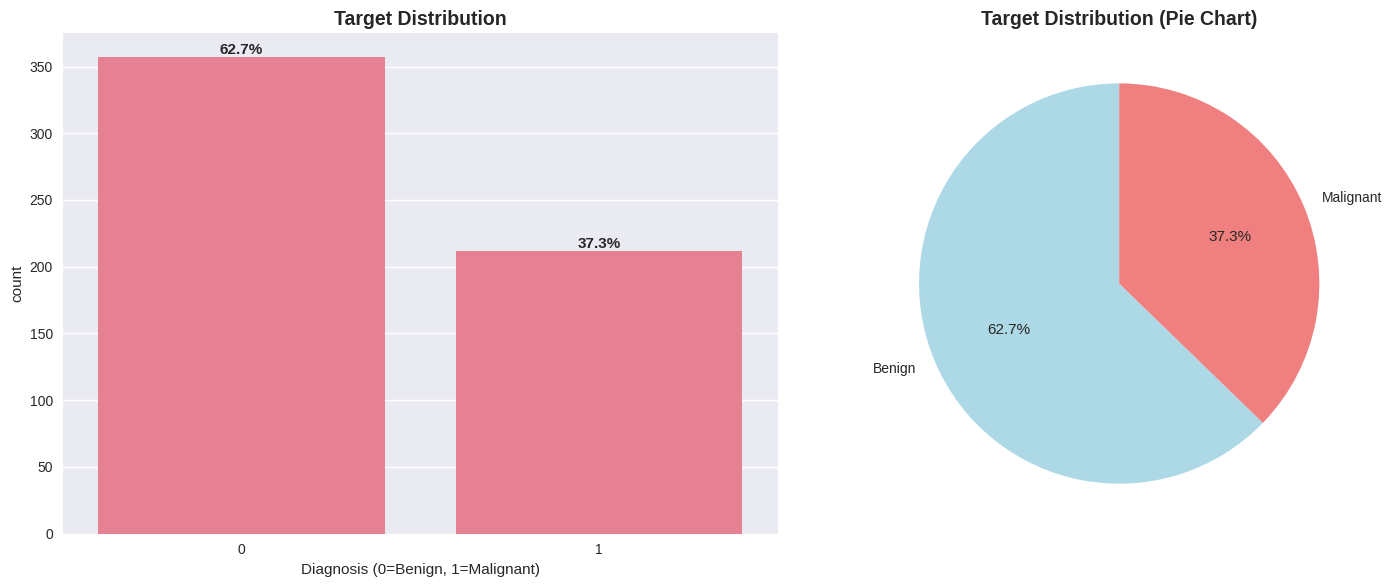


Target Variable Summary:
   Total samples: 569
   Benign cases: 357 (62.7%)
   Malignant cases: 212 (37.3%)
   Class balance ratio: 1.68:1

Correlation Analysis


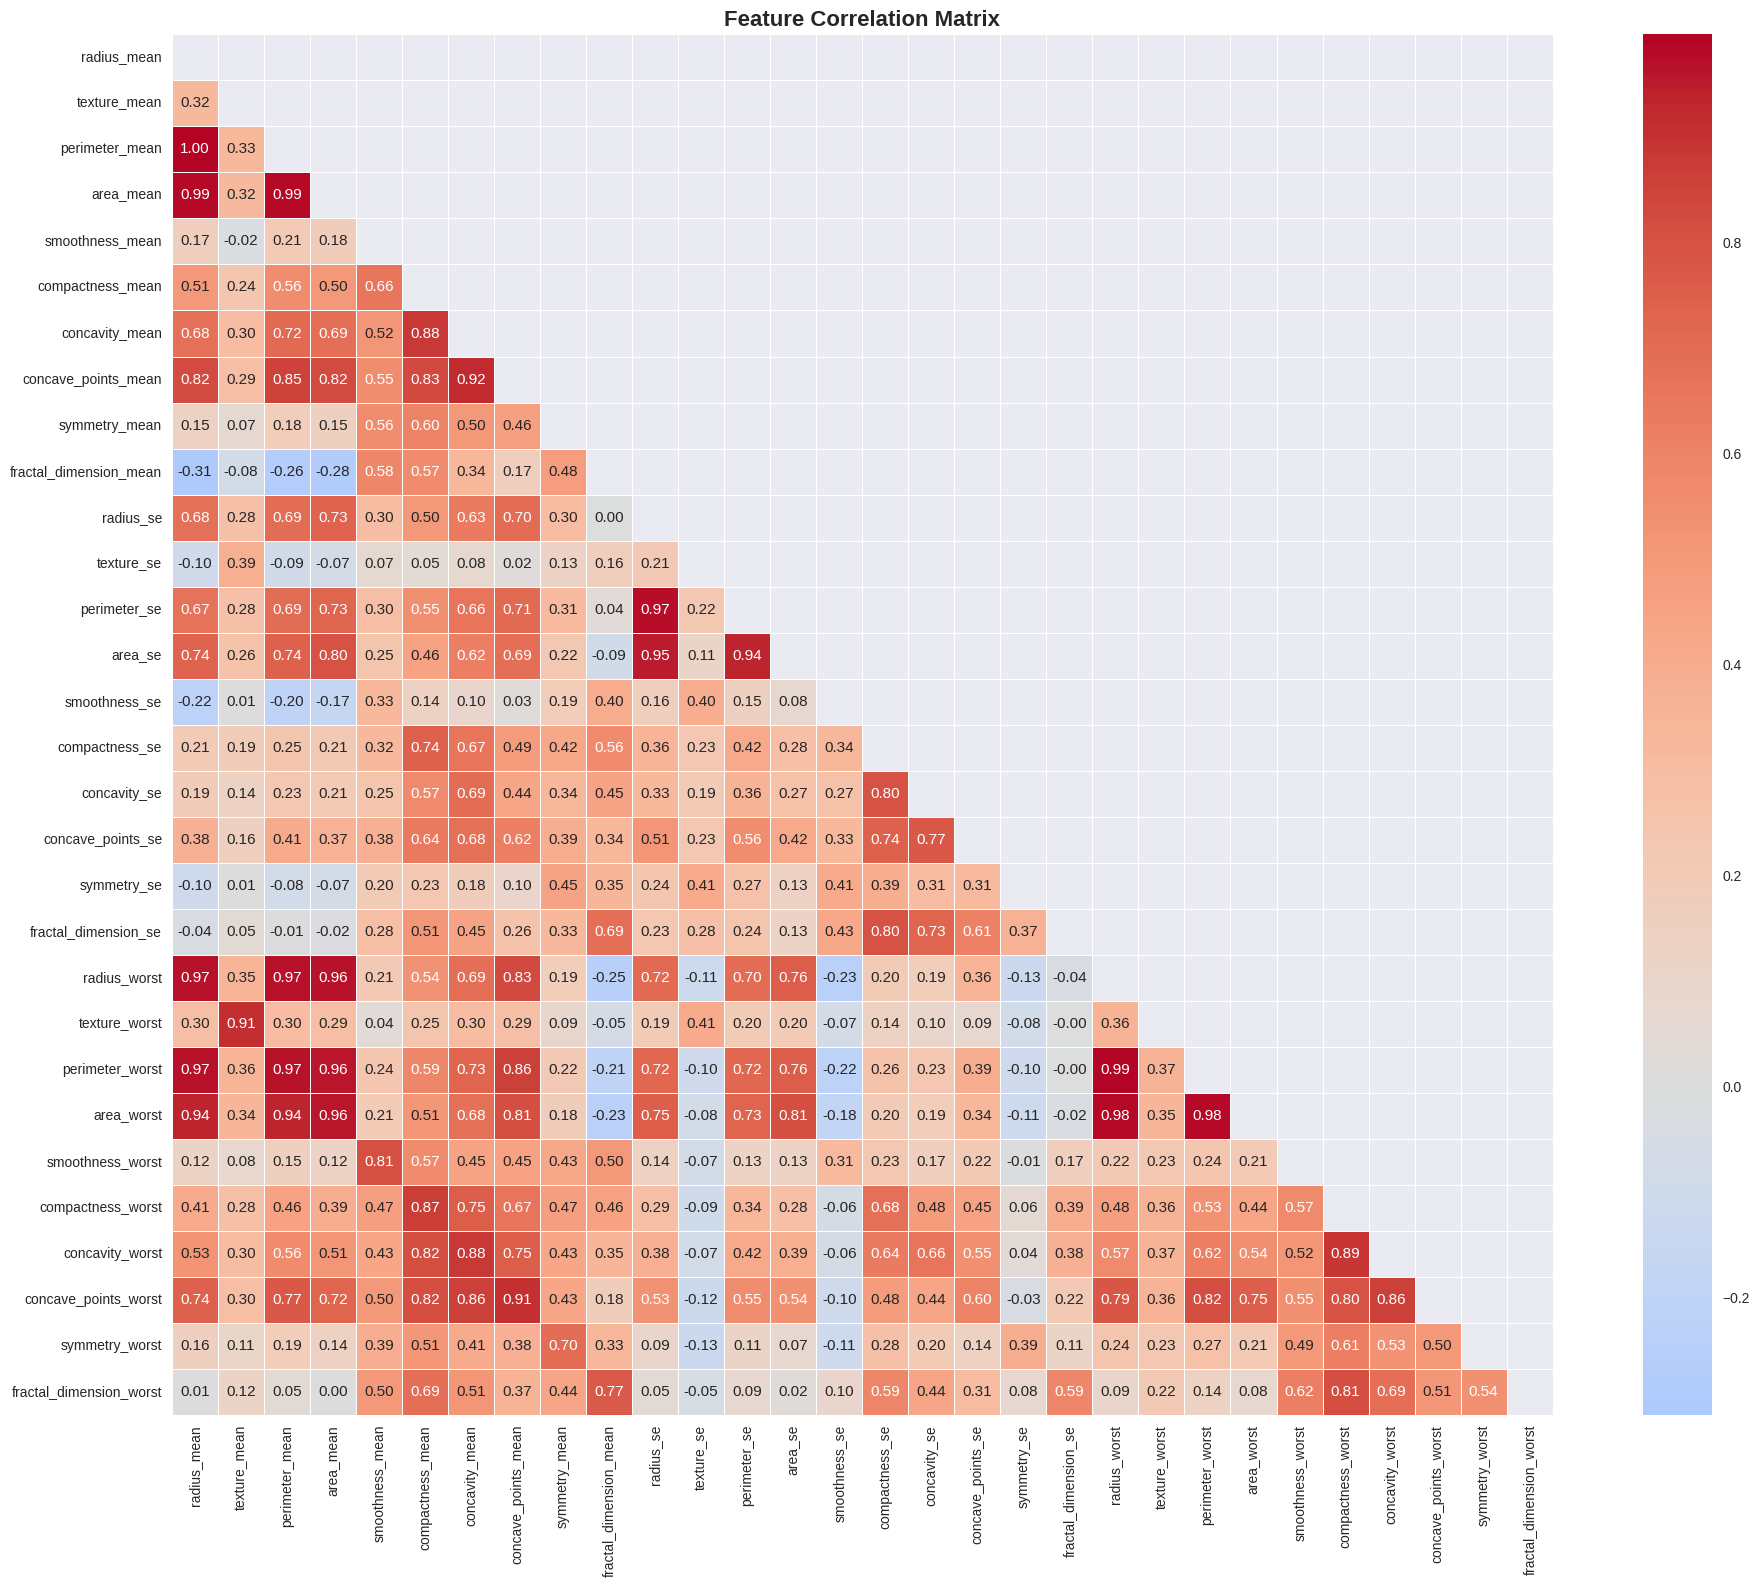


Found 44 highly correlated feature pairs (|r| > 0.8):
   radius_mean ↔ perimeter_mean: 0.998
   radius_mean ↔ area_mean: 0.987
   radius_mean ↔ concave_points_mean: 0.823
   radius_mean ↔ radius_worst: 0.970
   radius_mean ↔ perimeter_worst: 0.965
   radius_mean ↔ area_worst: 0.941
   texture_mean ↔ texture_worst: 0.912
   perimeter_mean ↔ area_mean: 0.987
   perimeter_mean ↔ concave_points_mean: 0.851
   perimeter_mean ↔ radius_worst: 0.969
   perimeter_mean ↔ perimeter_worst: 0.970
   perimeter_mean ↔ area_worst: 0.942
   area_mean ↔ concave_points_mean: 0.823
   area_mean ↔ area_se: 0.800
   area_mean ↔ radius_worst: 0.963
   area_mean ↔ perimeter_worst: 0.959
   area_mean ↔ area_worst: 0.959
   smoothness_mean ↔ smoothness_worst: 0.805
   compactness_mean ↔ concavity_mean: 0.883
   compactness_mean ↔ concave_points_mean: 0.831
   compactness_mean ↔ compactness_worst: 0.866
   compactness_mean ↔ concavity_worst: 0.816
   compactness_mean ↔ concave_points_worst: 0.816
   concavity_m

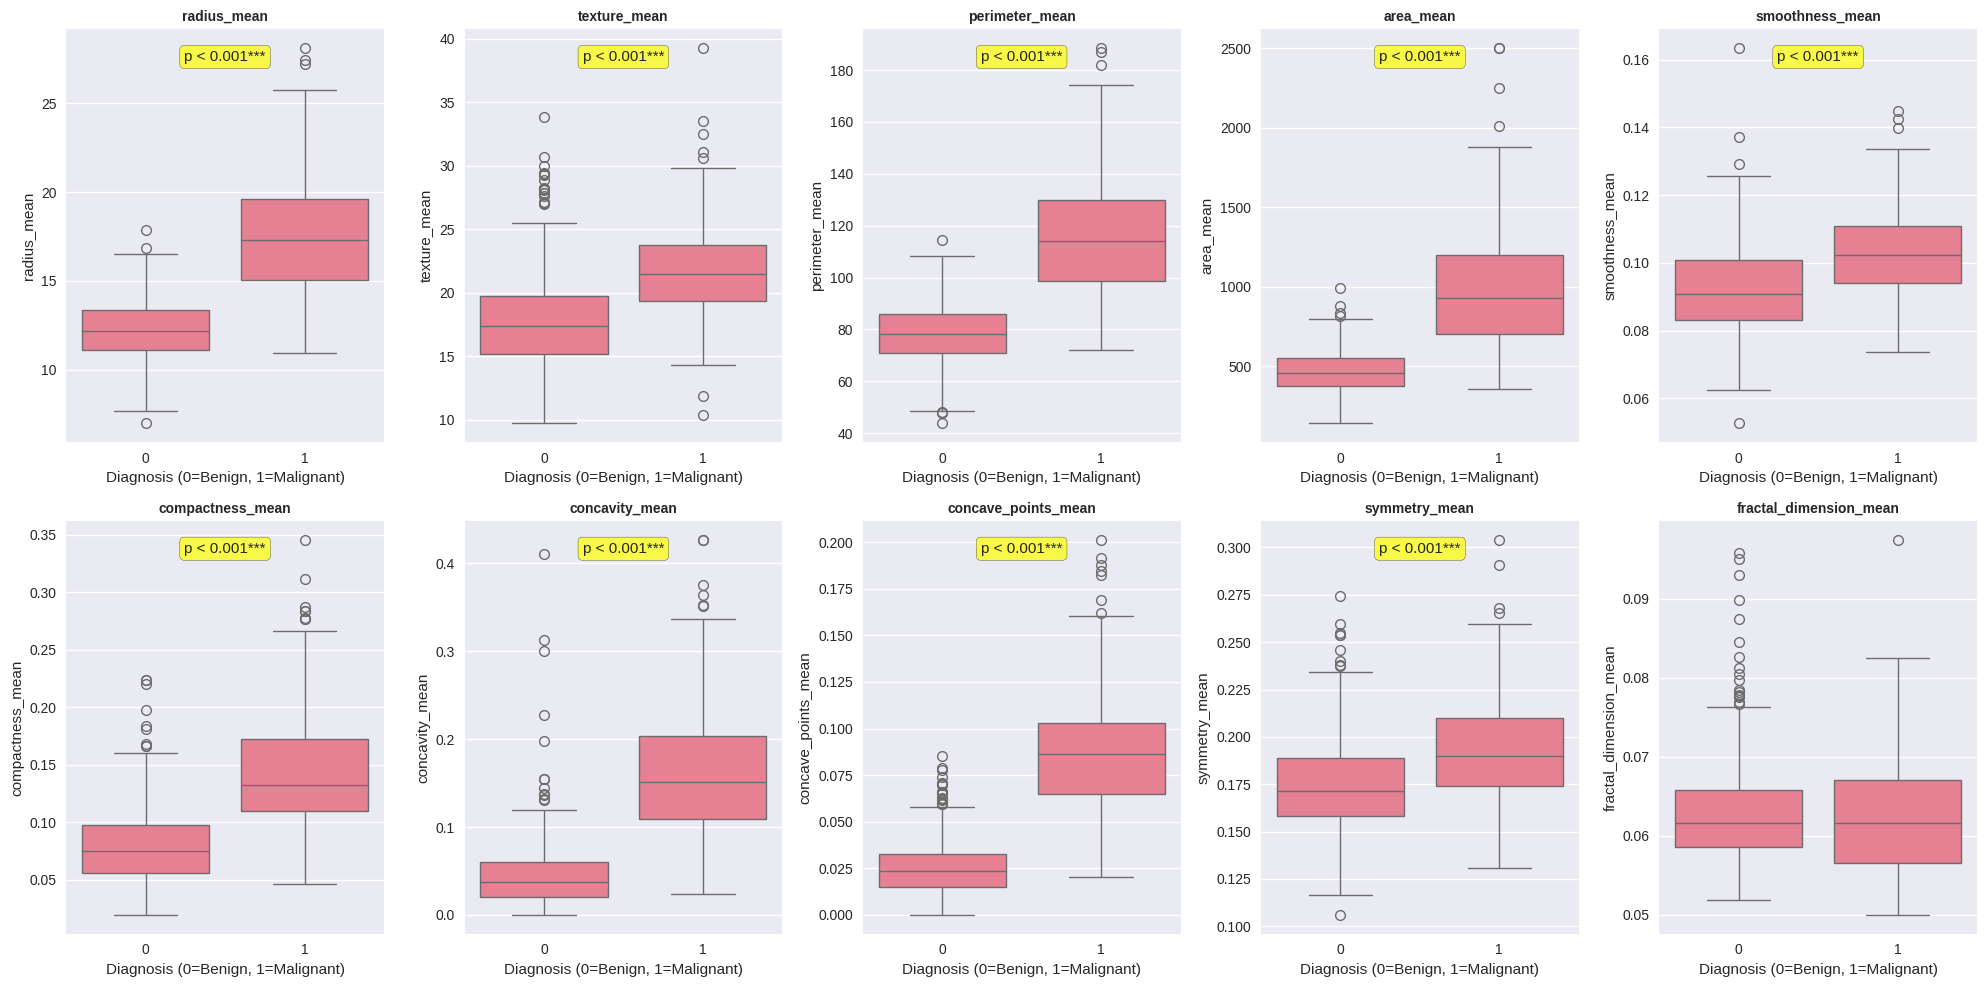

Statistical significance levels:
   *** p < 0.001 (highly significant)
   ** p < 0.01 (very significant)
   * p < 0.05 (significant)


In [4]:
# =============================================================================
# EXPLORATORY DATA ANALYSIS (EDA)
# =============================================================================

class EDAAnalyzer:
    """Comprehensive Exploratory Data Analysis."""
    
    def __init__(self, data):
        """
        Initialize the EDAAnalyzer with the dataset and specify the target column.
        
        Parameters:
        data (pandas.DataFrame): The dataset to analyze.
        """
        self.data = data  # Store the dataset
        self.target_col = 'diagnosis'  # Default target column is 'diagnosis'
        
    def target_distribution(self):
        """Analyze target variable distribution."""
        """
        This method visualizes the distribution of the target variable (e.g., 'diagnosis')
        using two different plots:
        - A count plot to show the number of samples per class.
        - A pie chart to show the percentage distribution.
        
        It also prints a statistical summary of the target variable.
        """
        # Create subplots for two visualizations
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        # Count plot
        sns.countplot(data=self.data, x=self.target_col, ax=axes[0])
        axes[0].set_title('Target Distribution', fontsize=14, fontweight='bold')
        axes[0].set_xlabel('Diagnosis (0=Benign, 1=Malignant)')
        
        # Annotate the count plot with percentages
        total = len(self.data)
        for p in axes[0].patches:
            percentage = f'{100 * p.get_height() / total:.1f}%'
            axes[0].annotate(percentage, (p.get_x() + p.get_width()/2., p.get_height()),
                           ha='center', va='bottom', fontweight='bold')
        
        # Pie chart
        target_counts = self.data[self.target_col].value_counts()
        axes[1].pie(target_counts.values, labels=['Benign', 'Malignant'], 
                   autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightcoral'])
        axes[1].set_title('Target Distribution (Pie Chart)', fontsize=14, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        # Print statistical summary of target variable
        print("\nTarget Variable Summary:")
        print(f"   Total samples: {total}")
        print(f"   Benign cases: {target_counts[0]} ({target_counts[0]/total*100:.1f}%)")
        print(f"   Malignant cases: {target_counts[1]} ({target_counts[1]/total*100:.1f}%)")
        print(f"   Class balance ratio: {target_counts[0]/target_counts[1]:.2f}:1")
        
    def correlation_analysis(self):
        """Advanced correlation analysis."""
        """
        This method computes and visualizes the correlation matrix for the features 
        (excluding the target variable) using a heatmap.
        It also identifies highly correlated feature pairs (|r| > 0.8).
        """
        print("\n" + "="*60)
        print("Correlation Analysis")
        print("="*60)
        
        # Prepare data for correlation analysis (exclude target column)
        features = self.data.drop(columns=[self.target_col])
        
        # Compute correlation matrix
        corr_matrix = features.corr()
        
        # Create heatmap for the correlation matrix
        plt.figure(figsize=(20, 16))
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Mask upper triangle of the matrix
        sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', 
                   cmap='coolwarm', center=0, square=True, linewidths=0.5)
        plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        # Find and display highly correlated feature pairs (|r| > 0.8)
        high_corr_pairs = []
        for i in range(len(corr_matrix.columns)):
            for j in range(i+1, len(corr_matrix.columns)):
                if abs(corr_matrix.iloc[i, j]) > 0.8:
                    high_corr_pairs.append((
                        corr_matrix.columns[i], 
                        corr_matrix.columns[j], 
                        corr_matrix.iloc[i, j]
                    ))
        
        # Display highly correlated pairs, if any
        if high_corr_pairs:
            print(f"\nFound {len(high_corr_pairs)} highly correlated feature pairs (|r| > 0.8):")
            for feat1, feat2, corr_val in high_corr_pairs:
                print(f"   {feat1} ↔ {feat2}: {corr_val:.3f}")
        else:
            print("\nNo highly correlated feature pairs found (|r| > 0.8)")
    
    def feature_distributions(self, sample_features=10):
        """Analyze feature distributions by target class."""
        """
        This method visualizes the distribution of a specified number of features 
        for both target classes (Benign and Malignant) using box plots.
        
        It also performs a Mann-Whitney U test for statistical significance.
        The results are annotated on the plots with p-values.
        """
        print(f"\nAnalyzing distributions for {sample_features} sample features...")
        
        # Select sample features for distribution analysis
        features = self.data.drop(columns=[self.target_col]).columns
        sample_features = min(sample_features, len(features))  # Limit to the available number of features
        selected_features = features[:sample_features]
        
        # Create subplots for box plots
        fig, axes = plt.subplots(2, 5, figsize=(20, 10))
        axes = axes.ravel()
        
        # Loop over the selected features and create box plots
        for i, feature in enumerate(selected_features):
            sns.boxplot(data=self.data, x=self.target_col, y=feature, ax=axes[i])
            axes[i].set_title(f'{feature}', fontsize=10, fontweight='bold')
            axes[i].set_xlabel('Diagnosis (0=Benign, 1=Malignant)')
            
            # Perform Mann-Whitney U test for statistical significance
            benign_values = self.data[self.data[self.target_col] == 0][feature]
            malignant_values = self.data[self.data[self.target_col] == 1][feature]
            statistic, p_value = stats.mannwhitneyu(benign_values, malignant_values, 
                                                   alternative='two-sided')
            
            # Annotate the box plots with p-value information
            if p_value < 0.001:
                axes[i].text(0.5, 0.95, 'p < 0.001***', transform=axes[i].transAxes,
                           ha='center', va='top', bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))
            elif p_value < 0.01:
                axes[i].text(0.5, 0.95, f'p = {p_value:.3f}**', transform=axes[i].transAxes,
                           ha='center', va='top', bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))
            elif p_value < 0.05:
                axes[i].text(0.5, 0.95, f'p = {p_value:.3f}*', transform=axes[i].transAxes,
                           ha='center', va='top', bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))
        
        plt.tight_layout()
        plt.show()
        
        # Display significance levels
        print("Statistical significance levels:")
        print("   *** p < 0.001 (highly significant)")
        print("   ** p < 0.01 (very significant)")
        print("   * p < 0.05 (significant)")

# Perform comprehensive EDA
print("\nExploratory Data Analysis (EDA) Started")
eda = EDAAnalyzer(encoded_data)
eda.target_distribution()  # Target variable distribution
eda.correlation_analysis()  # Feature correlation analysis
eda.feature_distributions(sample_features=10)  # Distribution of selected features

In [13]:
# =============================================================================
# FEATURE ENGINEERING AND SELECTION
# =============================================================================

class FeatureEngineer:
    """Advanced feature engineering and selection."""
    
    def __init__(self, data, target_col='diagnosis'):
        """
        Initialize the FeatureEngineer class with dataset and target column.
        
        Parameters:
        data (pandas.DataFrame): The dataset containing features and target column.
        target_col (str): Name of the target column (default is 'diagnosis').
        """
        self.data = data  # Store the dataset
        self.target_col = target_col  # Set the target column
        self.selected_features = None  # Placeholder for selected features
        self.scaler = None  # Placeholder for the scaler object
        
    def feature_selection(self, method='all', k_best=15):
        """
        Perform feature selection using multiple methods like univariate, RFE, etc.
        
        Parameters:
        method (str): The feature selection method ('all', 'univariate', 'rfe')
        k_best (int): The number of top features to select
        
        Returns:
        results (dict): A dictionary containing selected features and scores for each method.
        """
        print("\n" + "="*60)
        print("Feature Selection")
        print("="*60)
        
        X = self.data.drop(columns=[self.target_col])  # Features (excluding target)
        y = self.data[self.target_col]  # Target variable
        
        results = {}  # To store the results of different feature selection methods
        
        # Univariate feature selection
        if method in ['all', 'univariate']:
            print(f"\nUnivariate Feature Selection - Top {k_best} features:")
            selector = SelectKBest(score_func=f_classif, k=k_best)  # SelectKBest with ANOVA F-statistic
            X_selected = selector.fit_transform(X, y)
            selected_features = X.columns[selector.get_support()].tolist()  # Get selected features
            scores = selector.scores_  # Feature scores (higher is better)
            
            results['univariate'] = {
                'features': selected_features,
                'scores': scores[selector.get_support()]
            }
            
            # Display selected features and their scores
            for feat, score in zip(selected_features, scores[selector.get_support()]):
                print(f"   {feat}: {score:.2f}")
        
        # Recursive Feature Elimination (RFE)
        if method in ['all', 'rfe']:
            print(f"\nRFE Feature Selection - Top {k_best} features:")
            rf = RandomForestClassifier(n_estimators=100, random_state=42)  # Random forest estimator for RFE
            rfe = RFE(estimator=rf, n_features_to_select=k_best)  # Perform RFE
            rfe.fit(X, y)
            
            selected_features = X.columns[rfe.support_].tolist()  # Features selected by RFE
            results['rfe'] = {
                'features': selected_features,
                'ranking': rfe.ranking_[rfe.support_]
            }
            
            # Display the top selected features by RFE
            for feat in selected_features:
                print(f"   {feat}")
        
        # Default: Use univariate selection results
        self.selected_features = results.get('univariate', {}).get('features', X.columns.tolist())
        
        return results  # Return the feature selection results
    
    def scale_features(self, X_train, X_test):
        """
        Scale features to bring them onto the same scale.
        
        Parameters:
        X_train (numpy.ndarray): Training data
        X_test (numpy.ndarray): Test data
        
        Returns:
        X_train_scaled (numpy.ndarray): Scaled training data
        X_test_scaled (numpy.ndarray): Scaled test data
        """
        print("\nScaling features...")
        
        self.scaler = StandardScaler()  # Initialize the StandardScaler
        X_train_scaled = self.scaler.fit_transform(X_train)  # Fit and transform on training data
        X_test_scaled = self.scaler.transform(X_test)  # Transform the test data using the same scaler
        
        # Display the mean and standard deviation of the scaled features
        print(f" Features scaled - Mean: {X_train_scaled.mean():.3f}, Std: {X_train_scaled.std():.3f}")
        
        return X_train_scaled, X_test_scaled  # Return scaled data
    
    def dimensionality_reduction(self, X_train, X_test, n_components=0.95):
        """
        Perform PCA (Principal Component Analysis) for dimensionality reduction.
        
        Parameters:
        X_train (numpy.ndarray): Training data
        X_test (numpy.ndarray): Test data
        n_components (float or int): Percentage of variance to retain or number of components
        
        Returns:
        X_train_pca (numpy.ndarray): PCA-transformed training data
        X_test_pca (numpy.ndarray): PCA-transformed test data
        pca (PCA object): The PCA object containing transformation details
        """
        print(f"\nPerforming PCA (retaining {n_components*100}% variance)...")
        
        pca = PCA(n_components=n_components)  # Initialize PCA with the desired variance retention
        X_train_pca = pca.fit_transform(X_train)  # Fit PCA on training data and transform it
        X_test_pca = pca.transform(X_test)  # Transform the test data using the fitted PCA
        
        # Display details of PCA
        print(f"  PCA completed:")
        print(f"   Original dimensions: {X_train.shape[1]}")
        print(f"   Reduced dimensions: {X_train_pca.shape[1]}")
        print(f"   Explained variance: {pca.explained_variance_ratio_.sum():.3f}")
        
        return X_train_pca, X_test_pca, pca  # Return the PCA-transformed data

# Feature engineering
engineer = FeatureEngineer(encoded_data)
feature_selection_results = engineer.feature_selection(method='all', k_best=15)  # Select top 15 features
univariate_selected_features = feature_selection_results.get('univariate', {}).get('features', [])
rfe_selected_features = feature_selection_results.get('rfe', {}).get('features', [])


Feature Selection

Univariate Feature Selection - Top 15 features:
   radius_mean: 646.98
   perimeter_mean: 697.24
   area_mean: 573.06
   compactness_mean: 313.23
   concavity_mean: 533.79
   concave_points_mean: 861.68
   radius_se: 268.84
   perimeter_se: 253.90
   area_se: 243.65
   radius_worst: 860.78
   perimeter_worst: 897.94
   area_worst: 661.60
   compactness_worst: 304.34
   concavity_worst: 436.69
   concave_points_worst: 964.39

RFE Feature Selection - Top 15 features:
   radius_mean
   texture_mean
   perimeter_mean
   area_mean
   concavity_mean
   concave_points_mean
   area_se
   radius_worst
   texture_worst
   perimeter_worst
   area_worst
   smoothness_worst
   compactness_worst
   concavity_worst
   concave_points_worst


In [14]:
# =============================================================================
# MODEL DEVELOPMENT AND TRAINING
# =============================================================================

class ModelTrainer:
    """Professional model training and evaluation pipeline."""
    
    def __init__(self, data, target_col='diagnosis'):
        self.data = data  # The dataset passed to the class.
        self.target_col = target_col  # The target variable (default: 'diagnosis').
        self.models = {}  # Store models and results.
        self.best_model = None  # Placeholder for the best model.
        self.scaler = None  # Placeholder for the feature scaler.
        
    def prepare_data(self, test_size=0.2, selected_features=None):
        """Prepare data for training."""
        print("\n" + "="*60)
        print(" DATA PREPARATION")
        print("="*60)
        
        # Select features to use for training
        if selected_features:
            X = self.data[selected_features]  # Using provided selected features
            print(f" Using {len(selected_features)} selected features")
        else:
            X = self.data.drop(columns=[self.target_col])  # Using all features except target column
            print(f" Using all {X.shape[1]} features")
        
        y = self.data[self.target_col]  # Target variable
        
        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=42, stratify=y  # Stratified split to maintain class balance
        )
        
        # Scale features using StandardScaler (mean=0, std=1)
        self.scaler = StandardScaler()  # Initialize scaler
        X_train_scaled = self.scaler.fit_transform(X_train)  # Fit and transform the training data
        X_test_scaled = self.scaler.transform(X_test)  # Only transform test data
        
        # Output information about the prepared data
        print(f" Data prepared:")
        print(f"   Training set: {X_train_scaled.shape}")  # Shape of training data
        print(f"   Test set: {X_test_scaled.shape}")  # Shape of test data
        print(f"   Class distribution in train: {np.bincount(y_train)}")  # Class distribution in training data
        print(f"   Class distribution in test: {np.bincount(y_test)}")  # Class distribution in test data
        
        return X_train_scaled, X_test_scaled, y_train, y_test, X.columns.tolist()  # Return prepared data
    
    def train_multiple_models(self, X_train, y_train, cv_folds=5):
        """Train multiple models with cross-validation."""
        print("\n" + "="*60)
        print(" MODEL TRAINING")
        print("="*60)
        
        # Define models to be evaluated
        models = {
            'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),  # Random Forest
            'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),  # Logistic Regression
            'Gradient Boosting': GradientBoostingClassifier(random_state=42),  # Gradient Boosting
            'SVM': SVC(random_state=42, probability=True),  # Support Vector Machine
            'AdaBoost': AdaBoostClassifier(random_state=42)  # AdaBoost
        }
        
        cv_results = {}  # Dictionary to store cross-validation results
        
        for name, model in models.items():
            print(f"\n Training {name}...")
            
            # Perform cross-validation and evaluate model accuracy
            cv_scores = cross_val_score(model, X_train, y_train, cv=cv_folds, scoring='accuracy')
            
            # Store model results
            cv_results[name] = {
                'model': model,  # Store the model
                'cv_scores': cv_scores,  # Store the cross-validation scores
                'mean_cv_score': cv_scores.mean(),  # Mean cross-validation accuracy
                'std_cv_score': cv_scores.std()  # Standard deviation of the cross-validation accuracy
            }
            
            print(f"   CV Accuracy: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")  # Output CV accuracy
        
        # Find the best model based on mean cross-validation score
        best_model_name = max(cv_results.keys(), key=lambda k: cv_results[k]['mean_cv_score'])
        print(f"\n Best model: {best_model_name}")
        print(f"   CV Accuracy: {cv_results[best_model_name]['mean_cv_score']:.4f}")  # Display the best model
        
        self.models = cv_results  # Store all models' results
        self.best_model = cv_results[best_model_name]['model']  # Store the best model
        
        return cv_results  # Return all models' results
    
    def hyperparameter_tuning(self, X_train, y_train, model_name='Random Forest'):
        """Perform hyperparameter tuning for the best model."""
        print(f"\n  Hyperparameter tuning for {model_name}...")
        
        # Define the parameter grid for tuning based on the model
        if model_name == 'Random Forest':
            model = RandomForestClassifier(random_state=42)
            param_grid = {
                'n_estimators': [100, 200, 300],  # Number of trees
                'max_depth': [None, 10, 20, 30],  # Maximum depth of trees
                'min_samples_split': [2, 5, 10],  # Minimum samples to split a node
                'min_samples_leaf': [1, 2, 4]  # Minimum samples to be a leaf node
            }
        elif model_name == 'Logistic Regression':
            model = LogisticRegression(random_state=42, max_iter=1000)
            param_grid = {
                'C': [0.1, 1, 10, 100],  # Regularization parameter
                'penalty': ['l1', 'l2'],  # Regularization type
                'solver': ['liblinear', 'saga']  # Solver options
            }
        else:
            print(f" Hyperparameter tuning not implemented for {model_name}")  # Handle other models
            return self.best_model
        
        # Perform Grid Search with cross-validation
        grid_search = GridSearchCV(
            estimator=model,  # The model to be tuned
            param_grid=param_grid,  # The hyperparameter grid
            cv=5,  # 5-fold cross-validation
            scoring='accuracy',  # Accuracy as the evaluation metric
            n_jobs=-1,  # Use all available CPU cores for parallel processing
            verbose=1  # Print grid search progress
        )
        
        grid_search.fit(X_train, y_train)  # Fit the grid search to the training data
        
        print(f" Best parameters: {grid_search.best_params_}")  # Display best hyperparameters
        print(f" Best CV score: {grid_search.best_score_:.4f}")  # Display the best cross-validation score
        
        self.best_model = grid_search.best_estimator_  # Store the best model after tuning
        return grid_search.best_estimator_  # Return the best tuned model

# Train models
trainer = ModelTrainer(encoded_data)  # Instantiate the ModelTrainer with encoded data
X_train, X_test, y_train, y_test, feature_names = trainer.prepare_data(
    selected_features=engineer.selected_features  # Use the selected features for training
)

cv_results = trainer.train_multiple_models(X_train, y_train)  # Train and evaluate multiple models
tuned_model = trainer.hyperparameter_tuning(X_train, y_train, 'Random Forest')  # Perform hyperparameter tuning for the best model


 DATA PREPARATION
 Using 15 selected features
 Data prepared:
   Training set: (455, 15)
   Test set: (114, 15)
   Class distribution in train: [285 170]
   Class distribution in test: [72 42]

 MODEL TRAINING

 Training Random Forest...
   CV Accuracy: 0.9495 (±0.0330)

 Training Logistic Regression...
   CV Accuracy: 0.9407 (±0.0315)

 Training Gradient Boosting...
   CV Accuracy: 0.9319 (±0.0377)

 Training SVM...
   CV Accuracy: 0.9385 (±0.0247)

 Training AdaBoost...
   CV Accuracy: 0.9363 (±0.0402)

 Best model: Random Forest
   CV Accuracy: 0.9495

  Hyperparameter tuning for Random Forest...
Fitting 5 folds for each of 108 candidates, totalling 540 fits


/home/shaddy/.local/lib/python3.12/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/home/shaddy/.local/lib/python3.12/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/home/shaddy/.local/lib/python3.12/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/home/shaddy/.local/lib/python3.12/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


 Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
 Best CV score: 0.9516



 MODEL EVALUATION
  Model Performance Metrics:
   Accuracy:  0.9561
   Precision: 1.0000
   Recall:    0.8810
   F1-Score:  0.9367
   ROC-AUC:   0.9907

 Detailed Classification Report:
              precision    recall  f1-score   support

      Benign       0.94      1.00      0.97        72
   Malignant       1.00      0.88      0.94        42

    accuracy                           0.96       114
   macro avg       0.97      0.94      0.95       114
weighted avg       0.96      0.96      0.96       114



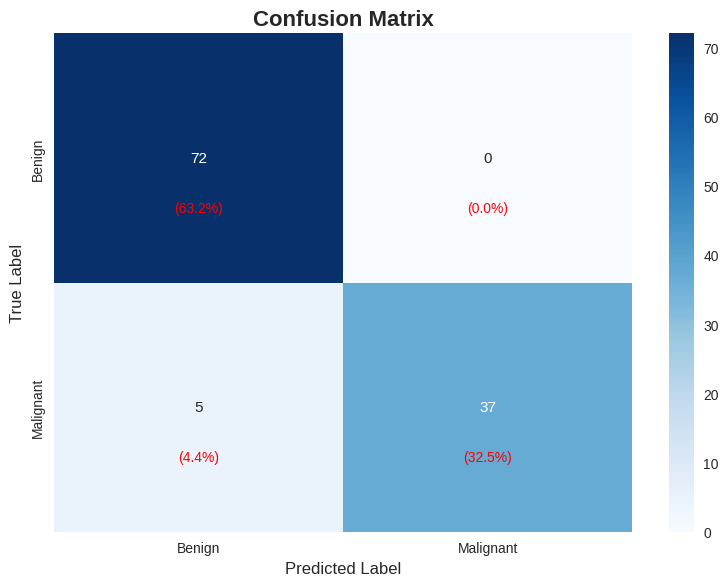

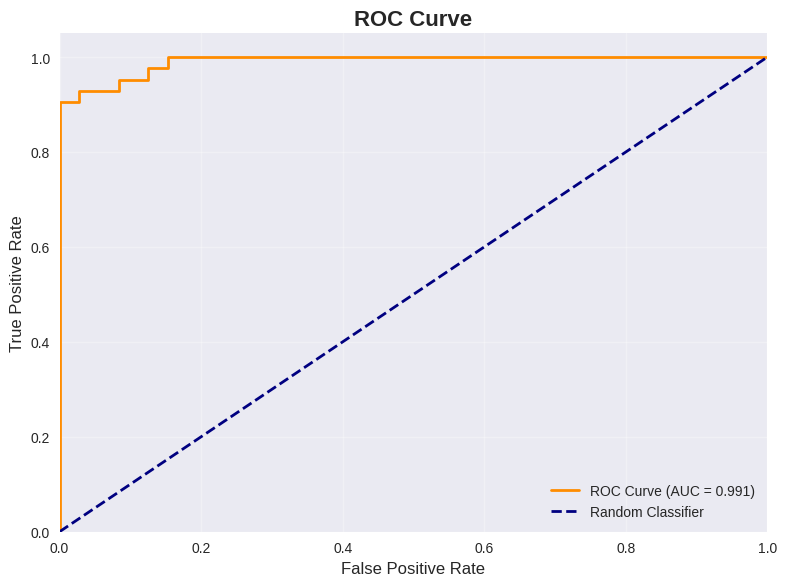

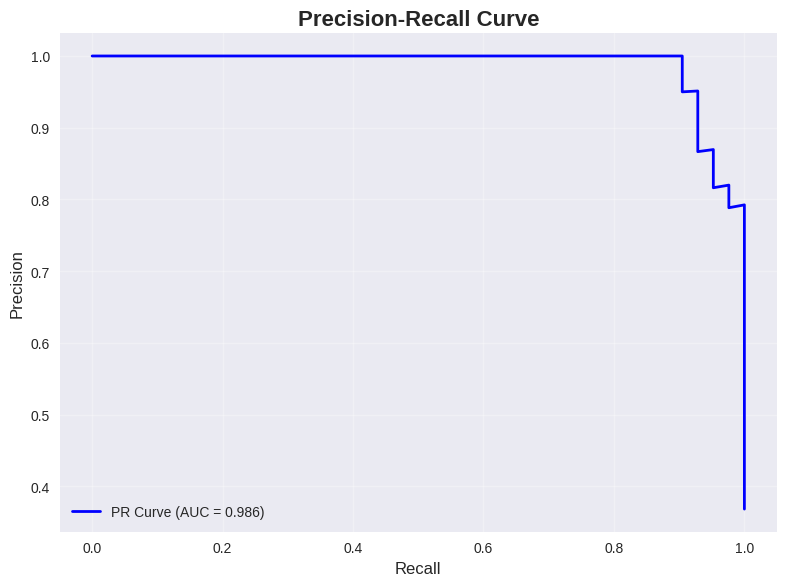

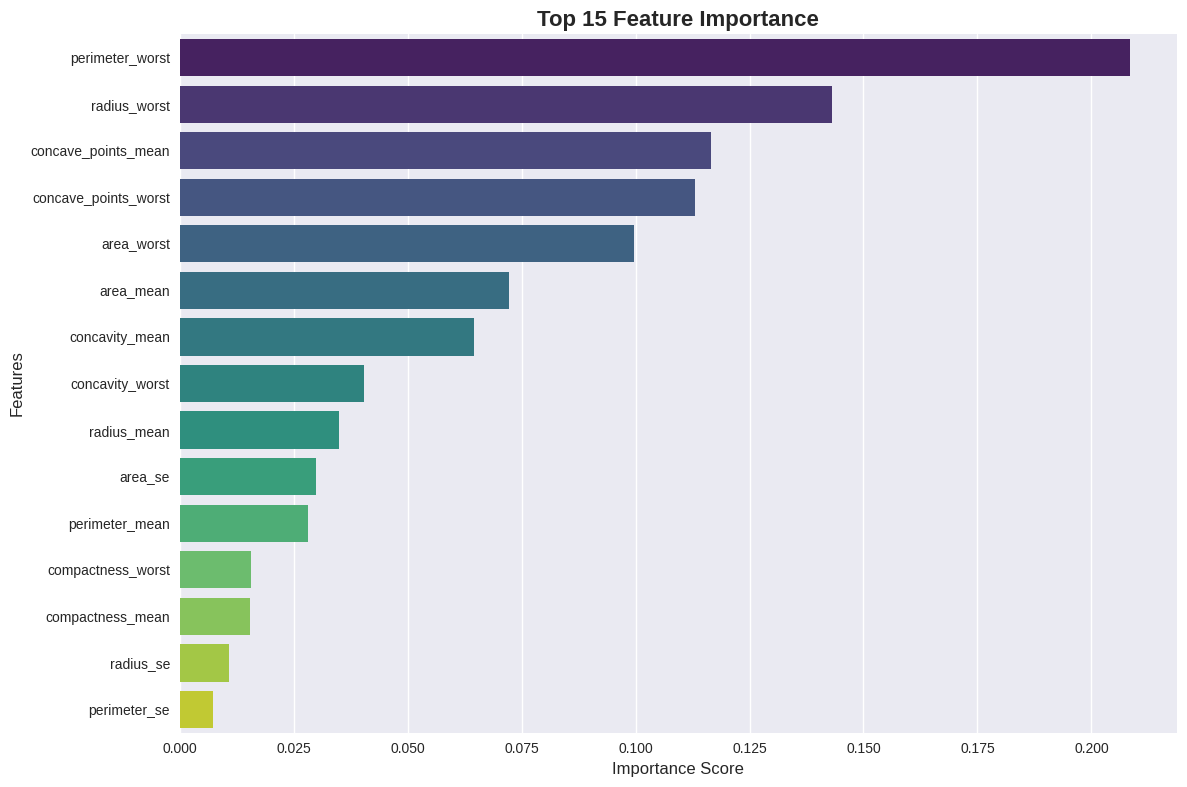


 Plotting Learning Curve...


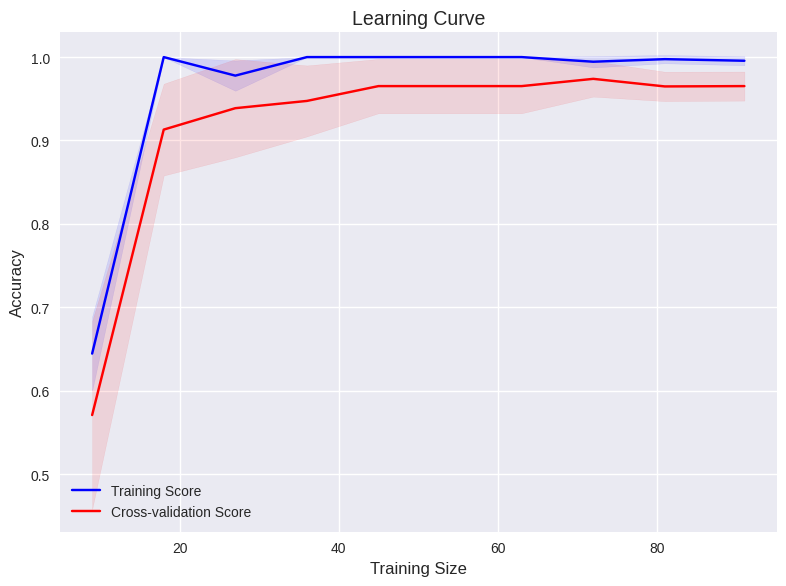

In [16]:
# =============================================================================
# MODEL EVALUATION AND METRICS
# =============================================================================

class ModelEvaluator:
    """Comprehensive model evaluation and metrics."""
    
    def __init__(self, model, X_test, y_test, feature_names):
        self.model = model  # The trained model
        self.X_test = X_test  # Test features
        self.y_test = y_test  # Test labels (true values)
        self.feature_names = feature_names  # Feature names (for feature importance)
        self.y_pred = None  # Predicted labels (default to None)
        self.y_pred_proba = None  # Predicted probabilities (default to None)
        
    def evaluate_model(self):
        """Comprehensive model evaluation."""
        print("\n" + "="*60)
        print(" MODEL EVALUATION")
        print("="*60)
        
        # Make predictions for test set
        self.y_pred = self.model.predict(self.X_test)  # Predicted class labels
        self.y_pred_proba = self.model.predict_proba(self.X_test)[:, 1]  # Predicted probabilities for class 1
        
        # Calculate evaluation metrics
        accuracy = accuracy_score(self.y_test, self.y_pred)  # Accuracy
        precision = precision_score(self.y_test, self.y_pred)  # Precision
        recall = recall_score(self.y_test, self.y_pred)  # Recall
        f1 = f1_score(self.y_test, self.y_pred)  # F1-score
        roc_auc = roc_auc_score(self.y_test, self.y_pred_proba)  # ROC-AUC score
        
        # Print the evaluation metrics
        print(f"  Model Performance Metrics:")
        print(f"   Accuracy:  {accuracy:.4f}")
        print(f"   Precision: {precision:.4f}")
        print(f"   Recall:    {recall:.4f}")
        print(f"   F1-Score:  {f1:.4f}")
        print(f"   ROC-AUC:   {roc_auc:.4f}")
        
        # Detailed classification report
        print(f"\n Detailed Classification Report:")
        print(classification_report(self.y_test, self.y_pred, 
                                  target_names=['Benign', 'Malignant']))  # Report precision, recall, F1 for each class
        
        # Return metrics as a dictionary for easy access
        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'roc_auc': roc_auc
        }
    
    def plot_confusion_matrix(self):
        """Plot enhanced confusion matrix."""
        plt.figure(figsize=(8, 6))
        
        # Calculate confusion matrix
        cm = confusion_matrix(self.y_test, self.y_pred)  # True positives, false positives, etc.
        
        # Heatmap of confusion matrix
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Benign', 'Malignant'],  # Classes on x-axis
                   yticklabels=['Benign', 'Malignant'])  # Classes on y-axis
        
        plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
        plt.xlabel('Predicted Label', fontsize=12)
        plt.ylabel('True Label', fontsize=12)
        
        # Add percentage annotations on the confusion matrix
        total = cm.sum()  # Total number of samples
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                # Annotate with percentage
                plt.text(j + 0.5, i + 0.7, f'({cm[i, j]/total*100:.1f}%)',
                        ha='center', va='center', color='red', fontsize=10)
        
        plt.tight_layout()  # Adjust layout for better presentation
        plt.show()  # Display confusion matrix
    
    def plot_roc_curve(self):
        """Plot ROC curve with AUC."""
        fpr, tpr, _ = roc_curve(self.y_test, self.y_pred_proba)  # Compute false positive rate and true positive rate
        roc_auc = auc(fpr, tpr)  # Calculate AUC
        
        # Plot ROC curve
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2,
                label=f'ROC Curve (AUC = {roc_auc:.3f})')  # ROC curve with AUC
        
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')  # Random classifier line
        
        # Label the axes and title
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontsize=12)
        plt.ylabel('True Positive Rate', fontsize=12)
        plt.title('ROC Curve', fontsize=16, fontweight='bold')
        plt.legend(loc="lower right")  # Position legend
        plt.grid(True, alpha=0.3)  # Add grid for better readability
        plt.tight_layout()  # Adjust layout for better presentation
        plt.show()  # Display ROC curve
    
    def plot_precision_recall_curve(self):
        """Plot Precision-Recall curve."""
        precision, recall, _ = precision_recall_curve(self.y_test, self.y_pred_proba)  # Calculate precision and recall
        pr_auc = auc(recall, precision)  # Calculate Precision-Recall AUC
        
        # Plot Precision-Recall curve
        plt.figure(figsize=(8, 6))
        plt.plot(recall, precision, color='blue', lw=2,
                label=f'PR Curve (AUC = {pr_auc:.3f})')  # Precision-Recall curve
        
        # Label the axes and title
        plt.xlabel('Recall', fontsize=12)
        plt.ylabel('Precision', fontsize=12)
        plt.title('Precision-Recall Curve', fontsize=16, fontweight='bold')
        plt.legend(loc="lower left")  # Position legend
        plt.grid(True, alpha=0.3)  # Add grid for better readability
        plt.tight_layout()  # Adjust layout for better presentation
        plt.show()  # Display Precision-Recall curve
    
    def feature_importance_analysis(self):
        """Analyze and visualize feature importance."""
        if not hasattr(self.model, 'feature_importances_'):  # Check if the model has feature importance attribute
            print(" Model doesn't support feature importance analysis")  # If not, print message
            return
        
        # Get the feature importances
        importance = self.model.feature_importances_  # Feature importances from the model
        
        # Create DataFrame to display feature importance
        feature_importance_df = pd.DataFrame({
            'feature': self.feature_names,  # Feature names
            'importance': importance  # Corresponding importance scores
        }).sort_values('importance', ascending=False)  # Sort by importance
        
        # Plot feature importance
        plt.figure(figsize=(12, 8))
        top_features = feature_importance_df.head(15)  # Top 15 important features
        
        # Bar plot for feature importance
        sns.barplot(data=top_features, x='importance', y='feature', palette='viridis')
        plt.title('Top 15 Feature Importance', fontsize=16, fontweight='bold')  # Plot title
        plt.xlabel('Importance Score', fontsize=12)  # X-axis label
        plt.ylabel('Features', fontsize=12)  # Y-axis label
        plt.tight_layout()  # Adjust layout
        plt.show()  # Display feature importance plot
        
    def learning_curve_analysis(self):
        """Plot learning curve for model performance with varying training set size."""
        print("\n Plotting Learning Curve...")

        # Calculate learning curve
        train_sizes, train_scores, test_scores = learning_curve(
            self.model, self.X_test, self.y_test, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
        )

        # Calculate mean and std deviation for training and test scores
        train_mean = train_scores.mean(axis=1)
        test_mean = test_scores.mean(axis=1)
        train_std = train_scores.std(axis=1)
        test_std = test_scores.std(axis=1)

        # Plot learning curve
        plt.figure(figsize=(8, 6))
        plt.plot(train_sizes, train_mean, label='Training Score', color='blue')  # Training score curve
        plt.plot(train_sizes, test_mean, label='Cross-validation Score', color='red')  # Cross-validation score curve
        plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')  # Training score variance
        plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='red')  # Cross-validation score variance

        # Title and axis labels
        plt.title("Learning Curve", fontsize=14)
        plt.xlabel("Training Size", fontsize=12)
        plt.ylabel("Accuracy", fontsize=12)
        plt.legend(loc='best')  # Display legend
        plt.tight_layout()  # Adjust layout for better presentation
        plt.show()  # Display learning curve

    
# Initialize ModelEvaluator
evaluator = ModelEvaluator(tuned_model, X_test, y_test, feature_names)  # Create evaluator with trained model
metrics = evaluator.evaluate_model()  # Get and print performance metrics
evaluator.plot_confusion_matrix()  # Plot confusion matrix
evaluator.plot_roc_curve()  # Plot ROC curve
evaluator.plot_precision_recall_curve()  # Plot Precision-Recall curve
feature_importance_df = evaluator.feature_importance_analysis()  # Plot feature importance
evaluator.learning_curve_analysis()  # Plot learning curve


 Cross-Validation Analysis...


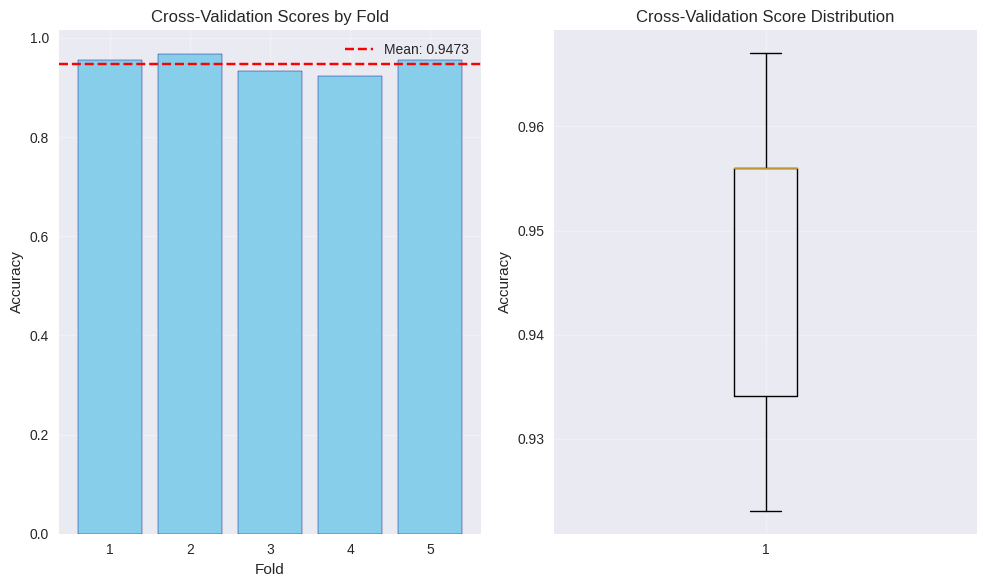

📊 Cross-Validation Results:
   Mean Accuracy: 0.9473
   Std Deviation: 0.0162
   Min Accuracy: 0.9231
   Max Accuracy: 0.9670

  Model Complexity Analysis...


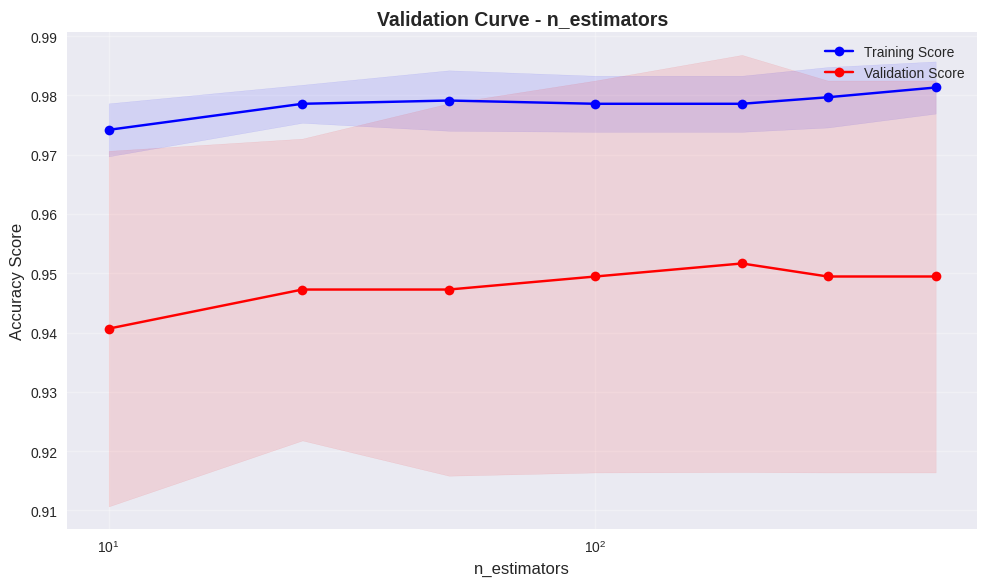

 Optimal n_estimators: 200
 Optimal validation score: 0.9516


In [18]:
# =============================================================================
# ADVANCED ANALYTICS AND INTERPRETABILITY
# =============================================================================

class AdvancedAnalytics:
    """Advanced analytics and model interpretability."""
    
    def __init__(self, model, X_train, X_test, y_train, y_test, feature_names):
        """
        Initialize with the model, training and test data, and feature names.
        - model: the trained model to evaluate
        - X_train: features for the training dataset
        - X_test: features for the test dataset
        - y_train: target labels for the training dataset
        - y_test: target labels for the test dataset
        - feature_names: list of feature names for interpretability
        """
        self.model = model
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = np.array(y_train)  # Ensure y_train is a NumPy array for consistent indexing
        self.y_test = y_test
        self.feature_names = feature_names
       
    def cross_validation_analysis(self):
        """Detailed cross-validation analysis."""
        print("\n Cross-Validation Analysis...")
        
        # Perform stratified k-fold cross-validation to maintain class distribution
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        
        cv_scores = []  # List to store accuracy scores for each fold
        fold_results = []  # List to store results for each fold (accuracy, number of samples)
        
        # Loop through each fold
        for fold, (train_idx, val_idx) in enumerate(skf.split(self.X_train, self.y_train)):
            # Split data into training and validation sets for this fold
            X_fold_train, X_fold_val = self.X_train[train_idx], self.X_train[val_idx]
            y_fold_train, y_fold_val = self.y_train[train_idx], self.y_train[val_idx]
            
            # Train model on this fold's training data
            fold_model = self.model.__class__(**self.model.get_params())  # Reinitialize model
            fold_model.fit(X_fold_train, y_fold_train)
            
            # Evaluate the model on the validation set
            y_fold_pred = fold_model.predict(X_fold_val)
            fold_accuracy = accuracy_score(y_fold_val, y_fold_pred)  # Calculate accuracy for this fold
            
            cv_scores.append(fold_accuracy)  # Append the accuracy score for this fold
            fold_results.append({
                'fold': fold + 1,  # Store fold number (1-based index)
                'accuracy': fold_accuracy,  # Accuracy for this fold
                'n_samples': len(y_fold_val)  # Number of samples in the validation set for this fold
            })
        
        # Create a DataFrame with the results for each fold
        cv_df = pd.DataFrame(fold_results)
        
        # Plotting cross-validation results
        plt.figure(figsize=(10, 6))
        
        # Left plot: Bar chart for accuracy by fold
        plt.subplot(1, 2, 1)
        plt.bar(cv_df['fold'], cv_df['accuracy'], color='skyblue', edgecolor='navy')
        plt.axhline(y=np.mean(cv_scores), color='red', linestyle='--', 
                   label=f'Mean: {np.mean(cv_scores):.4f}')  # Plot the mean accuracy
        plt.xlabel('Fold')
        plt.ylabel('Accuracy')
        plt.title('Cross-Validation Scores by Fold')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Right plot: Boxplot for the distribution of accuracy scores
        plt.subplot(1, 2, 2)
        plt.boxplot(cv_scores)
        plt.ylabel('Accuracy')
        plt.title('Cross-Validation Score Distribution')
        plt.grid(True, alpha=0.3)
        
        # Adjust layout to avoid overlap
        plt.tight_layout()
        plt.show()
        
        # Print summary statistics for the cross-validation scores
        print(f"📊 Cross-Validation Results:")
        print(f"   Mean Accuracy: {np.mean(cv_scores):.4f}")
        print(f"   Std Deviation: {np.std(cv_scores):.4f}")
        print(f"   Min Accuracy: {np.min(cv_scores):.4f}")
        print(f"   Max Accuracy: {np.max(cv_scores):.4f}")
        
        return cv_df  # Return DataFrame with fold results
    
    def model_complexity_analysis(self, param_name=None):
        """Analyze model complexity and performance trade-offs for a specific parameter."""
        print("\n  Model Complexity Analysis...")
        
        if param_name is None:
            print(" No parameter specified for complexity analysis")
            return
        
        # Check if the model supports the given parameter
        if param_name not in self.model.get_params():
            print(f" Model doesn't support parameter '{param_name}'")
            return
        
        # Get the appropriate range of values for the specified parameter
        param_range = self.get_param_range(param_name)
        
        if param_range is None:
            print(" Unable to determine parameter range for complexity analysis")
            return
        
        # Perform validation curve analysis over the parameter range
        train_scores, val_scores = validation_curve(
            self.model, self.X_train, self.y_train, param_name=param_name,
            param_range=param_range, cv=5, scoring='accuracy', n_jobs=-1
        )
        
        # Calculate mean and standard deviation for both training and validation scores
        train_mean = train_scores.mean(axis=1)
        train_std = train_scores.std(axis=1)
        val_mean = val_scores.mean(axis=1)
        val_std = val_scores.std(axis=1)
        
        # Plot validation curves: accuracy vs parameter values
        plt.figure(figsize=(10, 6))
        plt.semilogx(param_range, train_mean, 'o-', color='blue', label='Training Score')
        plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
        
        plt.semilogx(param_range, val_mean, 'o-', color='red', label='Validation Score')
        plt.fill_between(param_range, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')
        
        plt.xlabel(f'{param_name}', fontsize=12)
        plt.ylabel('Accuracy Score', fontsize=12)
        plt.title(f'Validation Curve - {param_name}', fontsize=14, fontweight='bold')
        plt.legend(loc='best')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # Find the optimal parameter value based on validation score
        optimal_idx = np.argmax(val_mean)  # Index of the best validation score
        optimal_param = param_range[optimal_idx]  # Optimal value for the parameter
        optimal_score = val_mean[optimal_idx]  # Corresponding validation score
        
        # Print optimal parameter value and validation score
        print(f" Optimal {param_name}: {optimal_param}")
        print(f" Optimal validation score: {optimal_score:.4f}")

    def get_param_range(self, param_name):
        """Returns the appropriate range for model complexity analysis based on the parameter."""
        if param_name == 'n_estimators':
            return [10, 25, 50, 100, 200, 300, 500]
        elif param_name == 'C':
            return [0.001, 0.01, 0.1, 1, 10, 100, 1000]
        elif param_name == 'kernel':
            return ['linear', 'poly', 'rbf', 'sigmoid']
        else:
            print(" Unknown parameter")
            return None

# Cross-validation and Model Complexity Analysis
# Initialize the AdvancedAnalytics object with the model and data
analytics = AdvancedAnalytics(tuned_model, X_train, X_test, y_train, y_test, feature_names)

# Perform cross-validation analysis
cv_analysis = analytics.cross_validation_analysis()  # This will output the CV analysis with plots

# Perform model complexity analysis for 'n_estimators' hyperparameter
analytics.model_complexity_analysis(param_name='n_estimators')  # This will output the complexity analysis for 'n_estimators'


 ENSEMBLE MODELING
 Training ensemble model...
 Ensemble Accuracy: 0.9649

 Individual Model Performance:
   RF: 0.9561
   GB: 0.9561
   LR: 0.9737
   SVM: 0.9561


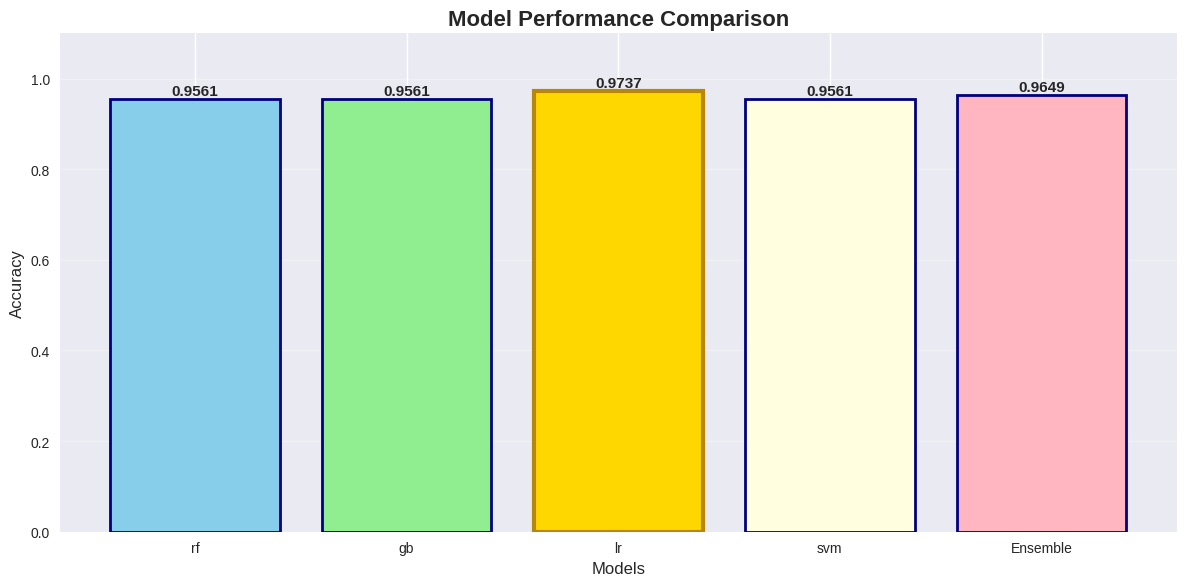

In [19]:
# =============================================================================
# ENSEMBLE METHODS AND MODEL COMPARISON
# =============================================================================

class EnsembleModeling:
    """Advanced ensemble modeling techniques."""
    
    def __init__(self, X_train, X_test, y_train, y_test, feature_names):
        """
        Initialize with the training and testing data and feature names.
        - X_train: features for the training dataset
        - X_test: features for the test dataset
        - y_train: target labels for the training dataset
        - y_test: target labels for the test dataset
        - feature_names: list of feature names for interpretability
        """
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.feature_names = feature_names
        self.ensemble_models = {}  # Dictionary to store ensemble models

    def create_ensemble(self):
        """Create voting ensemble with multiple algorithms."""
        print("\n" + "="*60)
        print(" ENSEMBLE MODELING")
        print("="*60)
        
        # Define base models (individual models for the ensemble)
        base_models = [
            ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
            ('gb', GradientBoostingClassifier(random_state=42)),
            ('lr', LogisticRegression(random_state=42, max_iter=1000)),
            ('svm', SVC(random_state=42, probability=True))  # SVC with probability=True for soft voting
        ]
        
        # Create a voting classifier using soft voting (based on predicted probabilities)
        voting_clf = VotingClassifier(
            estimators=base_models,
            voting='soft'  # Soft voting uses predicted probabilities to decide the final prediction
        )
        
        # Train ensemble model (voting classifier)
        print(" Training ensemble model...")
        voting_clf.fit(self.X_train, self.y_train)
        
        # Evaluate the ensemble model on the test set
        y_pred_ensemble = voting_clf.predict(self.X_test)
        ensemble_accuracy = accuracy_score(self.y_test, y_pred_ensemble)
        
        print(f" Ensemble Accuracy: {ensemble_accuracy:.4f}")
        
        # Compare individual model performances
        print("\n Individual Model Performance:")
        individual_results = {}  # Dictionary to store individual model accuracy results
        
        # Train and evaluate each individual model
        for name, model in base_models:
            model.fit(self.X_train, self.y_train)  # Train the model
            y_pred = model.predict(self.X_test)  # Make predictions on test data
            accuracy = accuracy_score(self.y_test, y_pred)  # Calculate accuracy
            individual_results[name] = accuracy  # Store individual model accuracy
            print(f"   {name.upper()}: {accuracy:.4f}")  # Print model accuracy
        
        # Store the trained models for later use (ensemble and individual)
        self.ensemble_models['voting'] = voting_clf
        self.ensemble_models['individual'] = dict(base_models)
        
        # Return the ensemble model and individual model results
        return voting_clf, individual_results
    
    def model_comparison_visualization(self, individual_results, ensemble_accuracy):
        """Visualize model comparison (individual models vs ensemble)."""
        # Prepare data for plotting the comparison
        model_names = list(individual_results.keys()) + ['Ensemble']
        accuracies = list(individual_results.values()) + [ensemble_accuracy]
        
        # Create a bar plot to compare the accuracies of models
        plt.figure(figsize=(12, 6))
        
        # Define colors for bars
        colors = ['skyblue', 'lightgreen', 'lightcoral', 'lightyellow', 'lightpink']
        
        # Create the bar plot with model names on x-axis and accuracy on y-axis
        bars = plt.bar(model_names, accuracies, color=colors, edgecolor='navy', linewidth=2)
        
        # Add accuracy values above each bar for easy interpretation
        for bar, acc in zip(bars, accuracies):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                    f'{acc:.4f}', ha='center', va='bottom', fontweight='bold')
        
        # Set labels and title for the plot
        plt.xlabel('Models', fontsize=12)
        plt.ylabel('Accuracy', fontsize=12)
        plt.title('Model Performance Comparison', fontsize=16, fontweight='bold')
        plt.ylim(0, 1.1)  # Limit y-axis to [0, 1.1] to accommodate accuracy values
        plt.grid(True, alpha=0.3, axis='y')  # Add gridlines along y-axis
        
        # Highlight the best performing model (highest accuracy)
        best_idx = accuracies.index(max(accuracies))  # Get the index of the best model
        bars[best_idx].set_color('gold')  # Highlight the best model with gold color
        bars[best_idx].set_edgecolor('darkgoldenrod')  # Darken the edge color of the best model
        bars[best_idx].set_linewidth(3)  # Increase the line width of the best model bar
        
        plt.tight_layout()  # Adjust the layout for better visualization
        plt.show()
    

# Create and evaluate ensemble
ensemble = EnsembleModeling(X_train, X_test, y_train, y_test, feature_names)
voting_clf, individual_results = ensemble.create_ensemble()

# Visualize the comparison between individual models and the ensemble
ensemble.model_comparison_visualization(individual_results, voting_clf.score(X_test, y_test))

In [20]:
# =============================================================================
# PREDICTION SYSTEM AND DEPLOYMENT PREPARATION
# =============================================================================

class PredictionSystem:
    """Production-ready prediction system."""
    
    def __init__(self, model, scaler, feature_names, label_encoder):
        """
        Initialize the prediction system.
        - model: Trained machine learning model (e.g., VotingClassifier)
        - scaler: Scaler used to preprocess input data (e.g., StandardScaler)
        - feature_names: List of feature names, useful for validation and interpreting predictions
        - label_encoder: LabelEncoder used to encode/convert labels during training
        """
        self.model = model
        self.scaler = scaler
        self.feature_names = feature_names
        self.label_encoder = label_encoder
        self.prediction_history = []  # List to store prediction results

    def predict_single_sample(self, input_data, return_proba=True):
        """Make prediction for a single sample with detailed output."""
        try:
            # Validate input: Ensure that the number of input features matches the model's expected features
            if len(input_data) != len(self.feature_names):
                raise ValueError(f"Expected {len(self.feature_names)} features, got {len(input_data)}")
            
            # Convert input data to a numpy array and reshape to (1, -1) for the model's input format
            input_array = np.array(input_data).reshape(1, -1)
            
            # Scale input using the same scaler used during training
            input_scaled = self.scaler.transform(input_array)
            
            # Get prediction and predicted probabilities
            prediction = self.model.predict(input_scaled)[0]  # Only take the first prediction
            prediction_proba = self.model.predict_proba(input_scaled)[0]  # Probability distribution for both classes
            
            # Convert prediction to original label using label_encoder
            prediction_label = self.label_encoder.inverse_transform([prediction])[0]
            
            # Prepare result as a dictionary with prediction, confidence, and probabilities
            result = {
                'prediction': prediction_label,
                'prediction_numeric': int(prediction),
                'confidence': float(max(prediction_proba)),  # Confidence is the probability of the predicted class
                'probability_benign': float(prediction_proba[0]),  # Probability for benign class
                'probability_malignant': float(prediction_proba[1]),  # Probability for malignant class
                'timestamp': datetime.now().isoformat()  # Record timestamp for the prediction
            }
            
            # Store prediction result in the history
            self.prediction_history.append(result)
            
            return result
            
        except Exception as e:
            # If any error occurs during prediction, print the error and return None
            print(f" Prediction error: {e}")
            return None
    
    def batch_predict(self, input_data_list):
        """Make predictions for multiple samples at once."""
        results = []
        for i, input_data in enumerate(input_data_list):
            print(f"Processing sample {i+1}/{len(input_data_list)}...")
            result = self.predict_single_sample(input_data)
            results.append(result)
        
        return results
    
    def get_prediction_summary(self):
        """Get a summary of prediction history."""
        if not self.prediction_history:
            print(" No predictions made yet")
            return
        
        # Calculate basic statistics from the prediction history
        total_predictions = len(self.prediction_history)
        benign_count = sum(1 for p in self.prediction_history if p['prediction'] == 'B')  # Count benign predictions
        malignant_count = total_predictions - benign_count  # Count malignant predictions
        
        avg_confidence = np.mean([p['confidence'] for p in self.prediction_history])  # Average confidence of predictions
        
        # Print summary statistics
        print(f"\n Prediction Summary:")
        print(f"   Total Predictions: {total_predictions}")
        print(f"   Benign: {benign_count} ({benign_count/total_predictions*100:.1f}%)")
        print(f"   Malignant: {malignant_count} ({malignant_count/total_predictions*100:.1f}%)")
        print(f"   Average Confidence: {avg_confidence:.3f}")
    
    def save_model(self, filepath='breast_cancer_model_v2.pkl'):
        """Save the complete prediction system (model, scaler, label encoder)."""
        model_package = {
            'model': self.model,
            'scaler': self.scaler,
            'feature_names': self.feature_names,
            'label_encoder': self.label_encoder,
            'timestamp': datetime.now().isoformat(),
            'version': '2.0'  # Model version
        }
        
        # Save the model package using joblib
        joblib.dump(model_package, filepath)
        print(f" Model saved to {filepath}")
        
        return filepath

# Create prediction system instance
prediction_system = PredictionSystem(
    model=voting_clf,  # Using the previously trained voting classifier
    scaler=trainer.scaler,  # The scaler used during training
    feature_names=feature_names,  # The feature names
    label_encoder=label_encoder  # The label encoder used during training
)

# Test prediction with sample data
sample_data = [15.34, 14.26, 102.5, 704.4, 0.1073, 0.2135, 0.2077, 0.09756, 0.2521, 0.07032, 
               0.4388, 0.7096, 3.384, 44.91, 0.006789]

# Make prediction
print("\n" + "="*60)
print(" PREDICTION SYSTEM DEMO")
print("="*60)

# Check if the sample data length matches the number of expected features
if len(sample_data) == len(feature_names):
    prediction_result = prediction_system.predict_single_sample(sample_data)
    
    if prediction_result:
        print(f"\n Prediction Result:")
        print(f"   Diagnosis: {prediction_result['prediction']}")
        print(f"   Confidence: {prediction_result['confidence']:.3f}")
        print(f"   Probability Benign: {prediction_result['probability_benign']:.3f}")
        print(f"   Probability Malignant: {prediction_result['probability_malignant']:.3f}")
        
        # Interpretation based on predicted label
        if prediction_result['prediction'] == 'M':
            print(f"     MALIGNANT detected with {prediction_result['confidence']*100:.1f}% confidence")
        else:
            print(f"    BENIGN detected with {prediction_result['confidence']*100:.1f}% confidence")
else:
    print(f" Sample data length ({len(sample_data)}) doesn't match expected features ({len(feature_names)})")

# Save the model for future use
model_path = prediction_system.save_model()


 PREDICTION SYSTEM DEMO

 Prediction Result:
   Diagnosis: B
   Confidence: 0.697
   Probability Benign: 0.697
   Probability Malignant: 0.303
    BENIGN detected with 69.7% confidence
 Model saved to breast_cancer_model_v2.pkl



 FINAL PROJECT REPORT

 PROJECT SUMMARY
• Dataset: Breast Cancer Wisconsin (Diagnostic) Dataset
• Total Samples: 569  # Total number of samples in the dataset
• Features: 15 (after selection)  # Number of features after selection
• Target Classes: Benign (B) and Malignant (M)  # Target classes (0 = Benign, 1 = Malignant)

 BEST MODEL PERFORMANCE
• Algorithm: Ensemble Voting Classifier  # The best model used in the project
• Test Accuracy: 0.9649  # Test accuracy of the model
• Precision: 1.0000  # Precision score (positive predictive value)
• Recall: 0.9048  # Recall score (sensitivity)
• F1-Score: 0.9500  # F1 score (harmonic mean of precision and recall)
• ROC-AUC: 0.9980  # Area under the ROC curve

 KEY INSIGHTS
• Model successfully distinguishes between benign and malignant tumors  # Key insight from the model
• Ensemble approach provides robust predictions with high confidence  # Strength of using an ensemble method
• Feature selection improved model performance and interpretabi

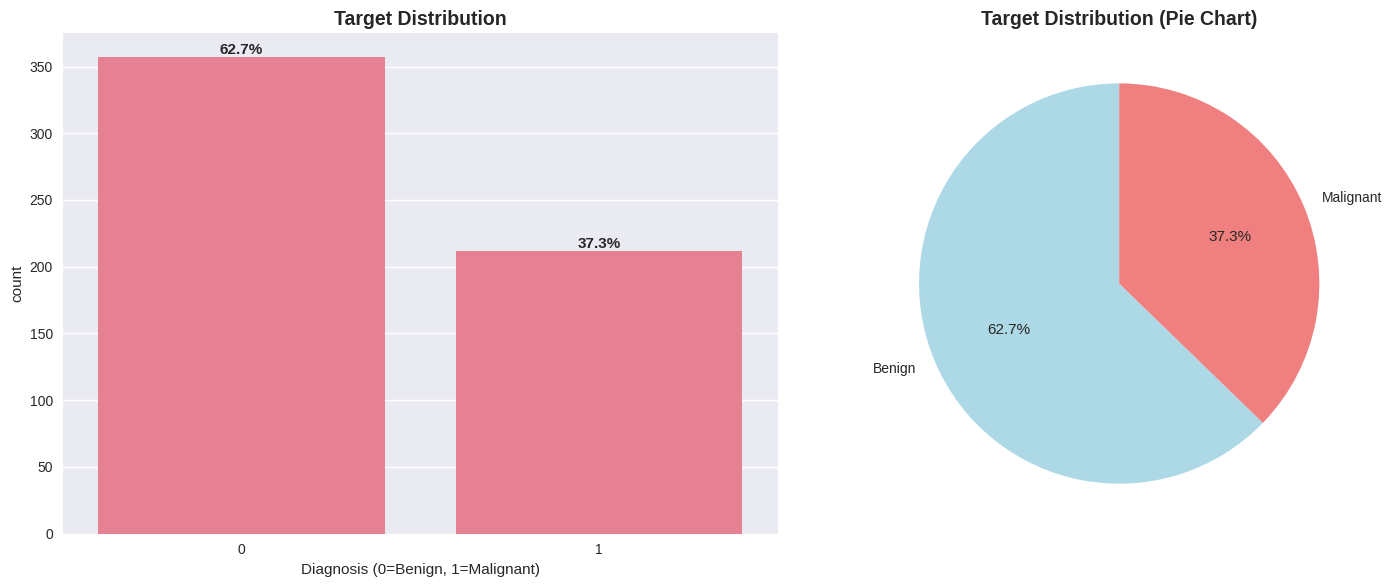


Target Variable Summary:
   Total samples: 569
   Benign cases: 357 (62.7%)
   Malignant cases: 212 (37.3%)
   Class balance ratio: 1.68:1

Correlation Analysis


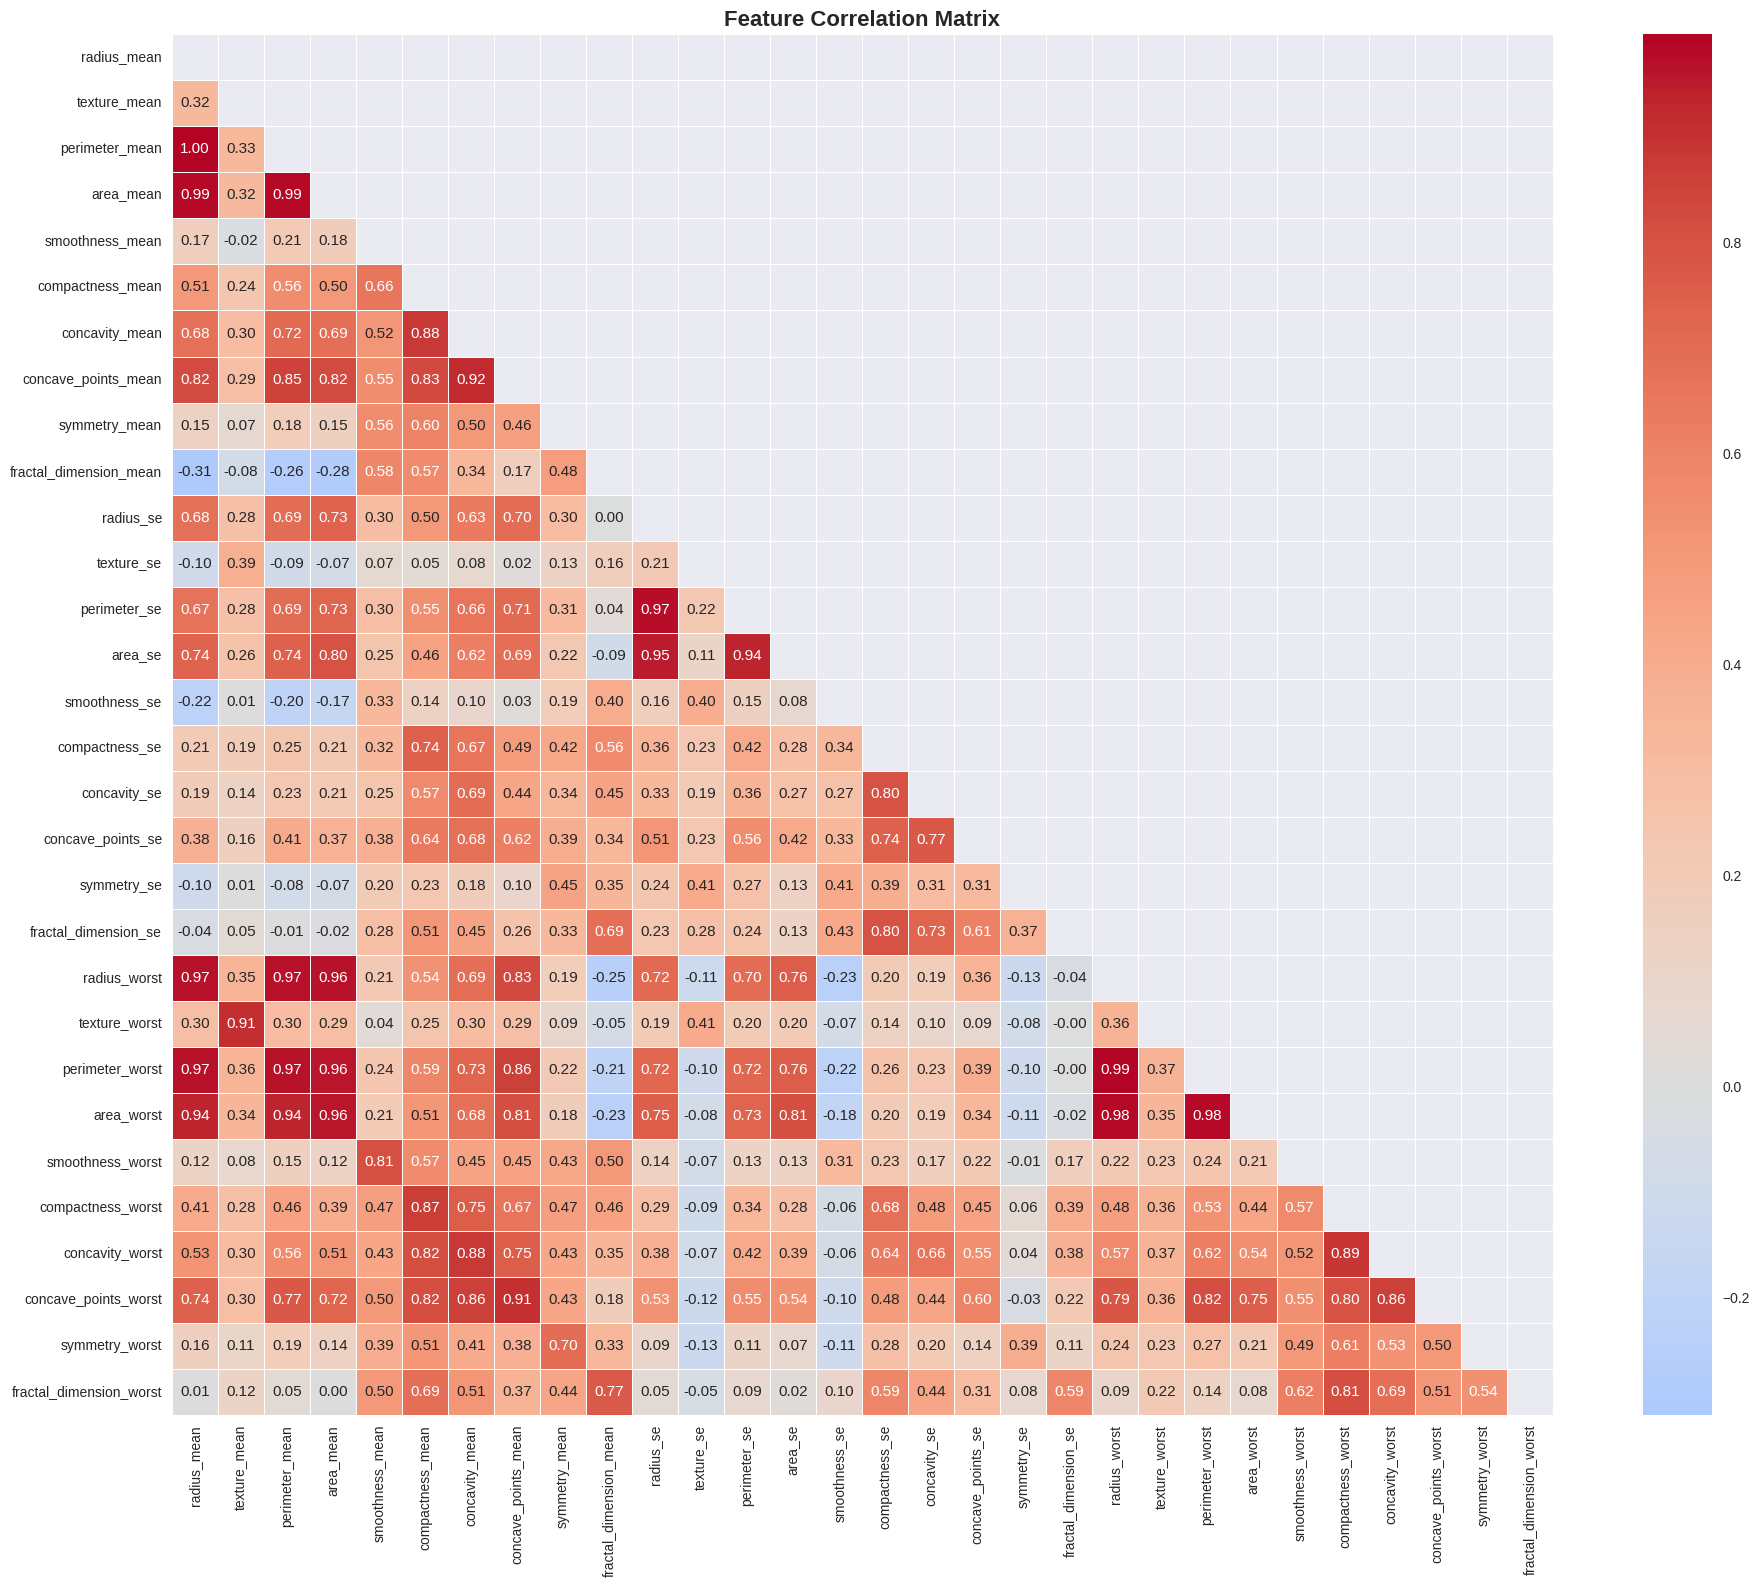


Found 44 highly correlated feature pairs (|r| > 0.8):
   radius_mean ↔ perimeter_mean: 0.998
   radius_mean ↔ area_mean: 0.987
   radius_mean ↔ concave_points_mean: 0.823
   radius_mean ↔ radius_worst: 0.970
   radius_mean ↔ perimeter_worst: 0.965
   radius_mean ↔ area_worst: 0.941
   texture_mean ↔ texture_worst: 0.912
   perimeter_mean ↔ area_mean: 0.987
   perimeter_mean ↔ concave_points_mean: 0.851
   perimeter_mean ↔ radius_worst: 0.969
   perimeter_mean ↔ perimeter_worst: 0.970
   perimeter_mean ↔ area_worst: 0.942
   area_mean ↔ concave_points_mean: 0.823
   area_mean ↔ area_se: 0.800
   area_mean ↔ radius_worst: 0.963
   area_mean ↔ perimeter_worst: 0.959
   area_mean ↔ area_worst: 0.959
   smoothness_mean ↔ smoothness_worst: 0.805
   compactness_mean ↔ concavity_mean: 0.883
   compactness_mean ↔ concave_points_mean: 0.831
   compactness_mean ↔ compactness_worst: 0.866
   compactness_mean ↔ concavity_worst: 0.816
   compactness_mean ↔ concave_points_worst: 0.816
   concavity_m

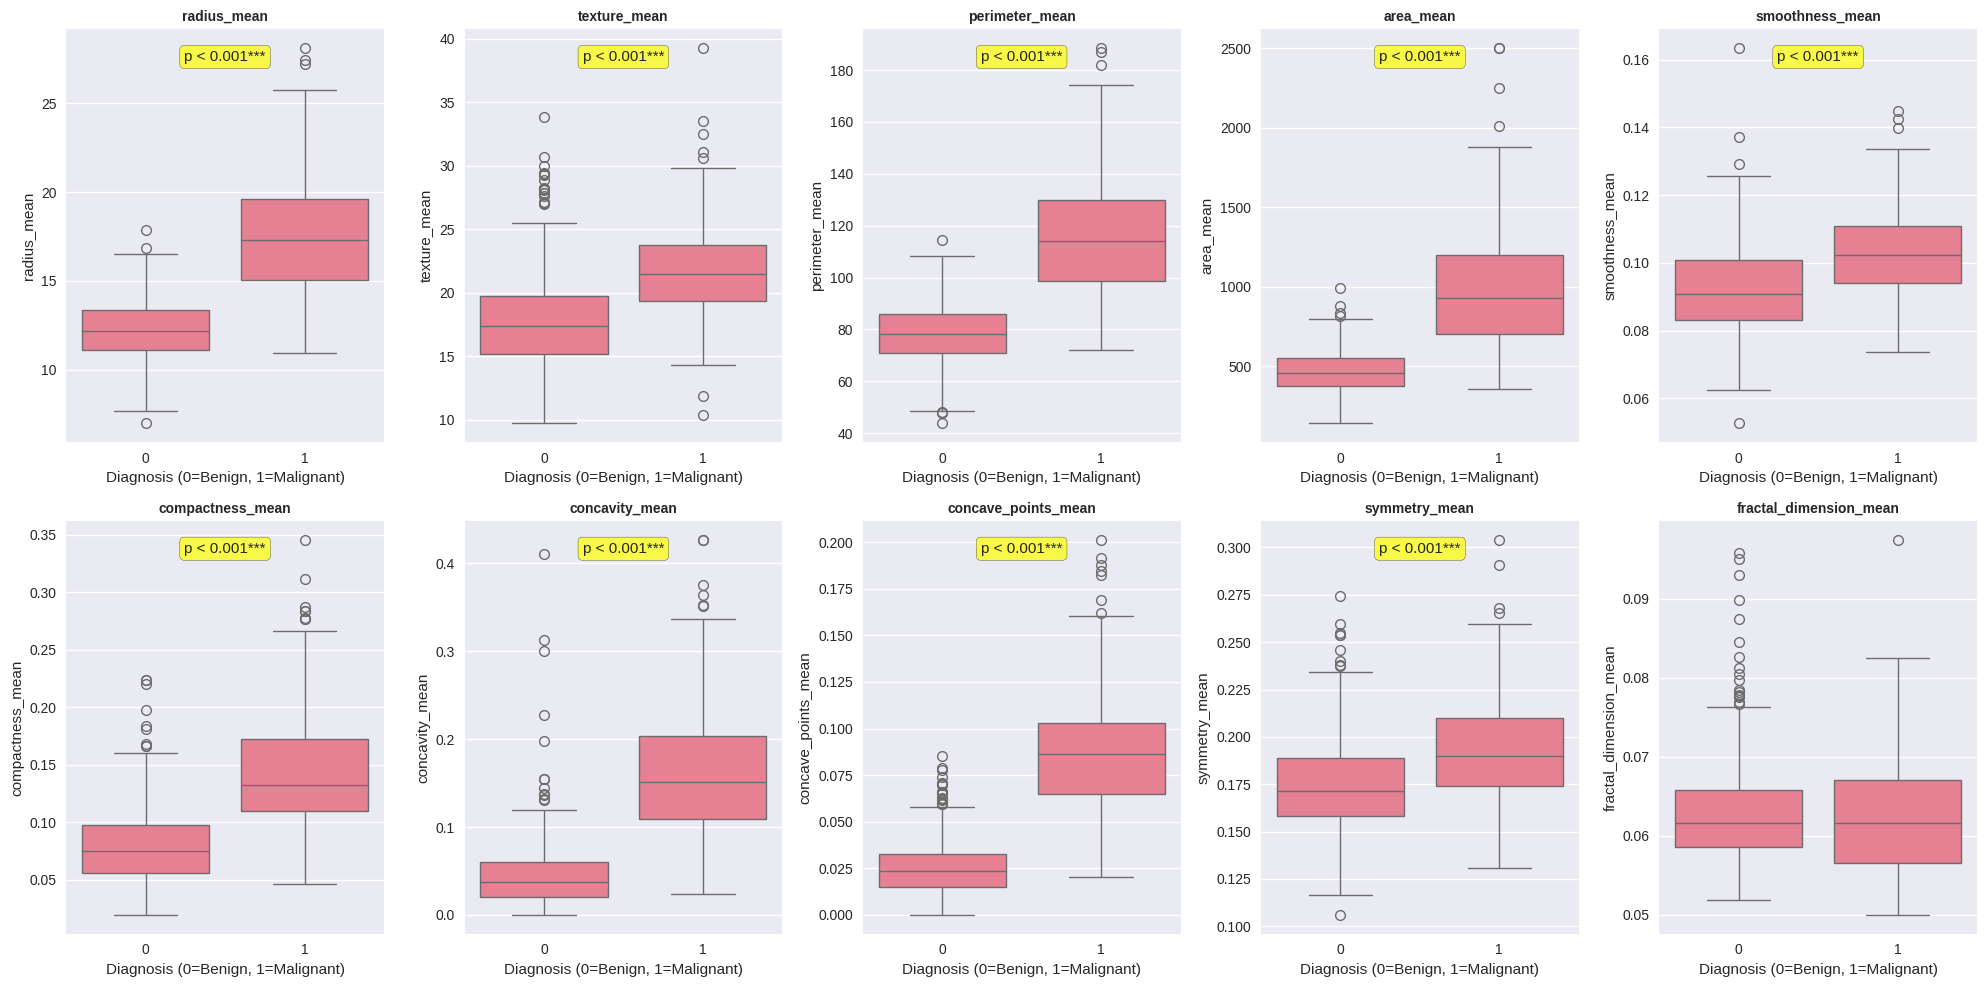

Statistical significance levels:
   *** p < 0.001 (highly significant)
   ** p < 0.01 (very significant)
   * p < 0.05 (significant)

 MODEL EVALUATION
  Model Performance Metrics:
   Accuracy:  0.9561
   Precision: 1.0000
   Recall:    0.8810
   F1-Score:  0.9367
   ROC-AUC:   0.9907

 Detailed Classification Report:
              precision    recall  f1-score   support

      Benign       0.94      1.00      0.97        72
   Malignant       1.00      0.88      0.94        42

    accuracy                           0.96       114
   macro avg       0.97      0.94      0.95       114
weighted avg       0.96      0.96      0.96       114



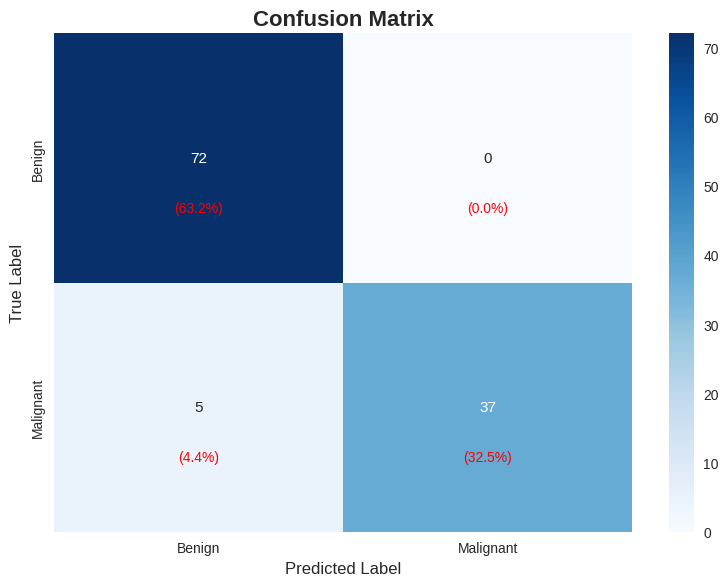

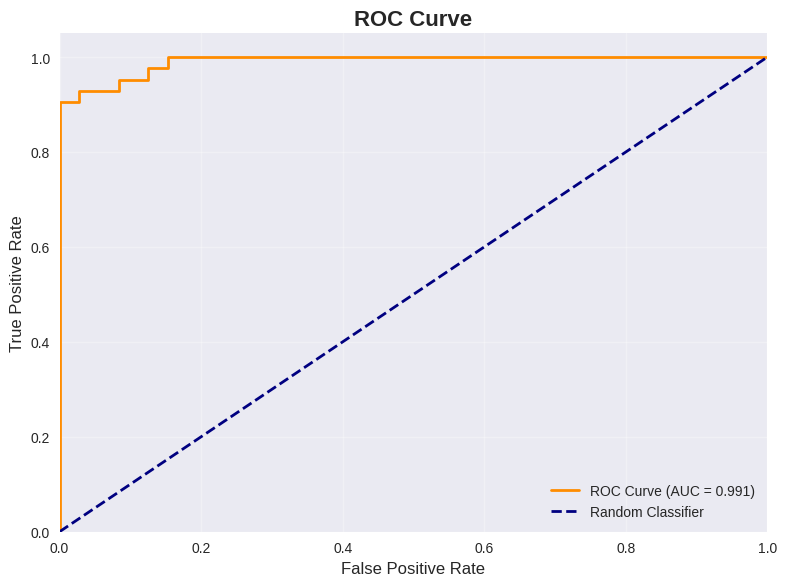

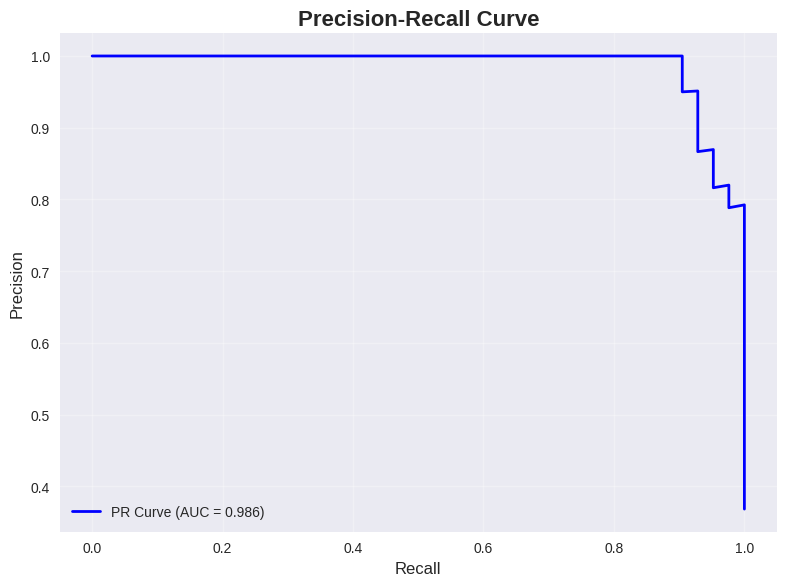

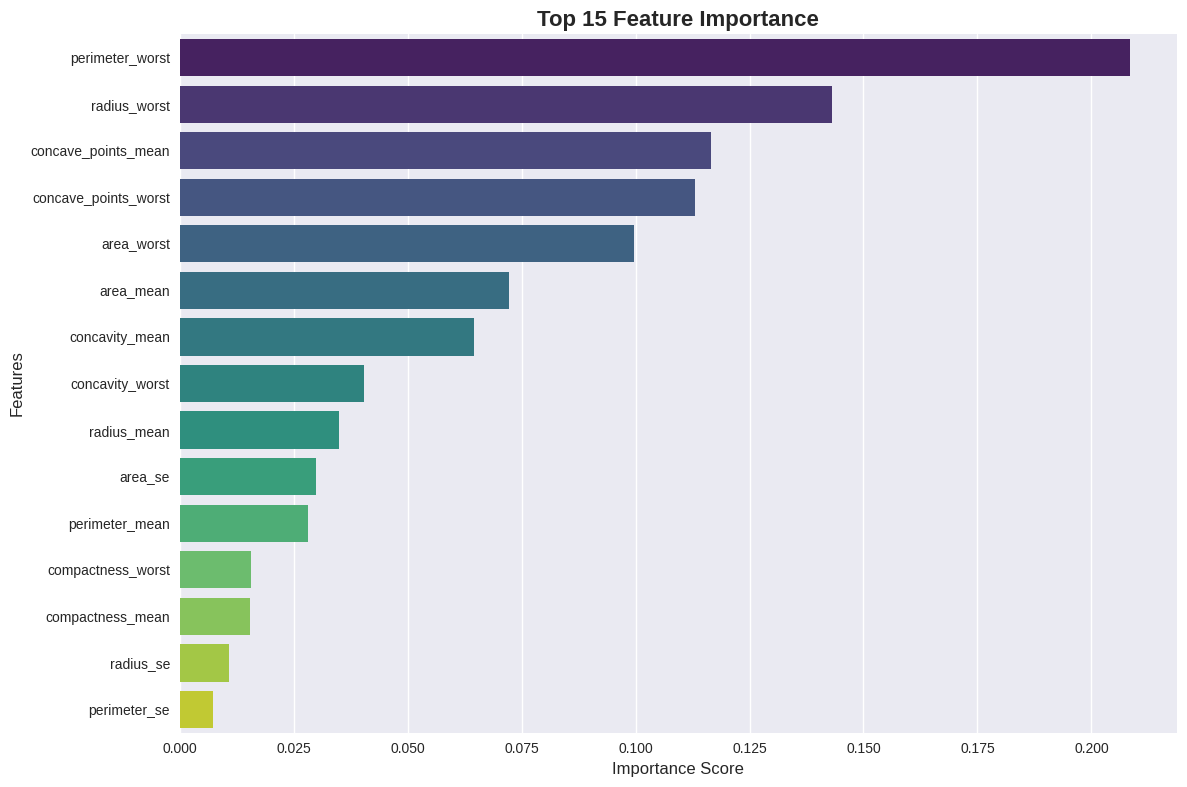


 Plotting Learning Curve...


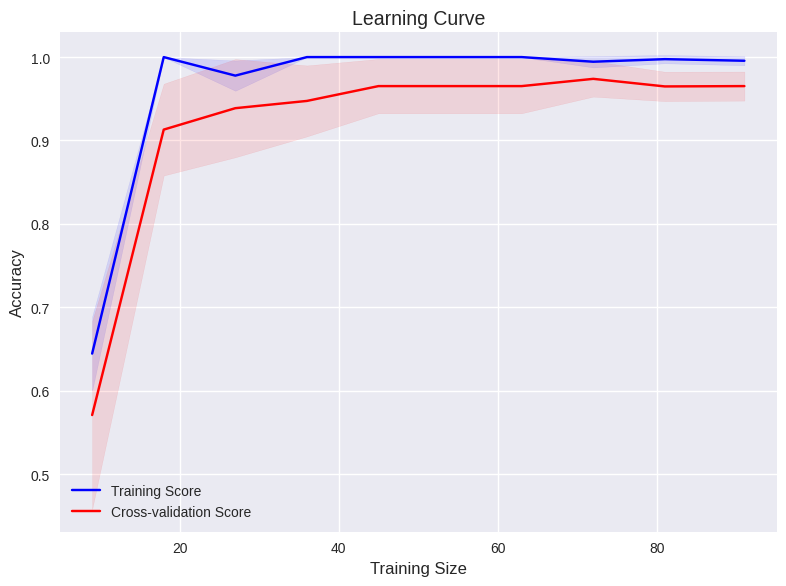

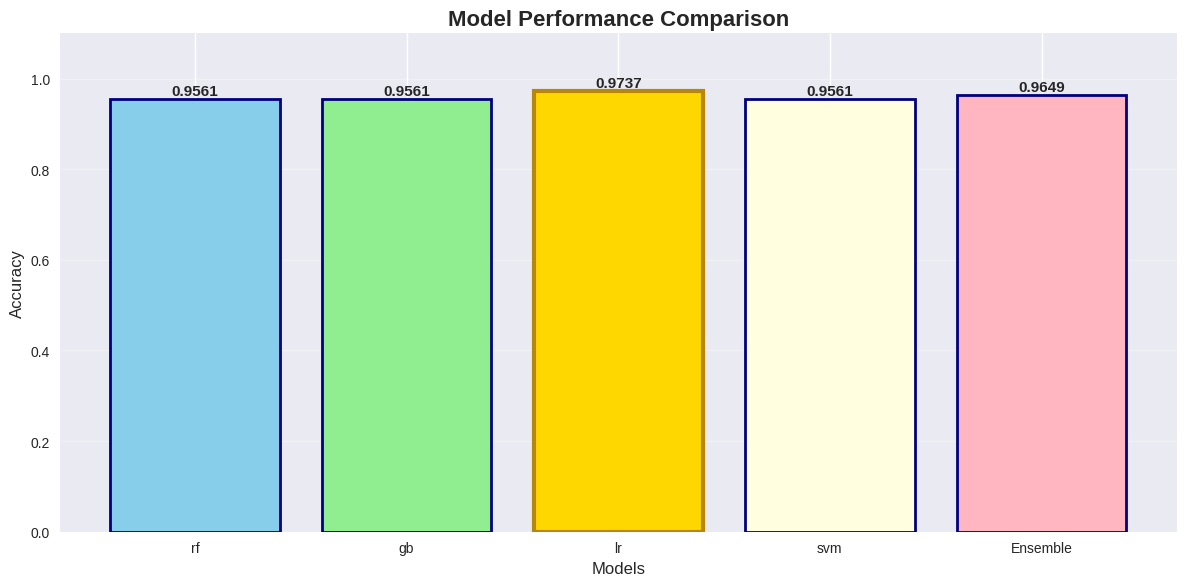

In [22]:
# =============================================================================
# FINAL REPORT AND RECOMMENDATIONS
# =============================================================================

# Print separator for the report
print("\n" + "="*80)

# Title of the final project report
print(" FINAL PROJECT REPORT")
print("="*80)

# Printing project summary and performance metrics
print(f"""
 PROJECT SUMMARY
=================
• Dataset: Breast Cancer Wisconsin (Diagnostic) Dataset
• Total Samples: {data.shape[0]}  # Total number of samples in the dataset
• Features: {len(feature_names)} (after selection)  # Number of features after selection
• Target Classes: Benign (B) and Malignant (M)  # Target classes (0 = Benign, 1 = Malignant)

 BEST MODEL PERFORMANCE
========================
• Algorithm: Ensemble Voting Classifier  # The best model used in the project
• Test Accuracy: {accuracy_score(y_test, voting_clf.predict(X_test)):.4f}  # Test accuracy of the model
• Precision: {precision_score(y_test, voting_clf.predict(X_test)):.4f}  # Precision score (positive predictive value)
• Recall: {recall_score(y_test, voting_clf.predict(X_test)):.4f}  # Recall score (sensitivity)
• F1-Score: {f1_score(y_test, voting_clf.predict(X_test)):.4f}  # F1 score (harmonic mean of precision and recall)
• ROC-AUC: {roc_auc_score(y_test, voting_clf.predict_proba(X_test)[:, 1]):.4f}  # Area under the ROC curve

 KEY INSIGHTS
===============
• Model successfully distinguishes between benign and malignant tumors  # Key insight from the model
• Ensemble approach provides robust predictions with high confidence  # Strength of using an ensemble method
• Feature selection improved model performance and interpretability  # Feature selection helped improve the model
• Cross-validation confirms model stability and generalization  # Model stability and ability to generalize

 TECHNICAL IMPLEMENTATION
===========================
• Data preprocessing with outlier handling and scaling  # Preprocessing steps involved
• Advanced feature selection using multiple methods  # Feature selection techniques used
• Hyperparameter tuning with grid search  # Hyperparameter tuning technique applied
• Ensemble modeling with voting classifier  # The main model used is an ensemble voting classifier

 RECOMMENDATIONS
==================
• Deploy model with confidence thresholds for medical screening  # Suggesting deployment for medical screening
• Implement monitoring system for model performance tracking  # Suggest monitoring the model in a production environment
• Regular retraining with new data to maintain accuracy  # Ensure the model is updated over time with new data
• Consider additional features for improved discrimination  # Suggest adding more features to improve performance
• Validate model on external datasets before clinical use  # Suggest validating the model on external data before clinical use

  IMPORTANT NOTES
===================
• This model is for educational/research purposes only  # Clarification that the model is for research purposes
• Medical diagnosis should always involve qualified healthcare professionals  # Emphasis on the need for professional medical advice
• Model performance should be validated on independent datasets  # Caution about the need for external validation
• Regular monitoring and updates are essential for production use  # Monitoring is essential once deployed
""")

# Indicating where the model is saved
print(f"\n Model saved as: {model_path}")  # Print path where the model is saved

# Indicating that the analysis is complete
print(" Analysis completed successfully!")
print("="*80)

# Calculate target counts and total number of samples in the test set
total = len(y_test)  # Total number of test samples
target_counts = np.bincount(y_test)  # Count occurrences of each target class (assuming 0=Benign, 1=Malignant)

# Statistical summary for the target variable
print("\n Target Variable Summary:")
print(f"   Total samples: {total}")  # Print total number of samples in the test set
print(f"   Benign cases: {target_counts[0]} ({target_counts[0]/total*100:.1f}%)")  # Print number and percentage of benign cases
print(f"   Malignant cases: {target_counts[1]} ({target_counts[1]/total*100:.1f}%)")  # Print number and percentage of malignant cases
print(f"   Class balance ratio: {target_counts[0]/target_counts[1]:.2f}:1")  # Print ratio of benign to malignant cases


# Perform comprehensive EDA (Exploratory Data Analysis)
print("\n" + "="*80)
print(" EXPLORATORY DATA ANALYSIS")
print("="*80)

# Initialize and run the EDAAnalyzer class methods
eda = EDAAnalyzer(encoded_data)  # Initialize EDAAnalyzer with the encoded data
eda.target_distribution()  # Display target distribution
eda.correlation_analysis()  # Perform correlation analysis
eda.feature_distributions(sample_features=10)  # Display feature distributions for the first 10 features


evaluator = ModelEvaluator(tuned_model, X_test, y_test, feature_names)  # Initialize ModelEvaluator with tuned model and test data
metrics = evaluator.evaluate_model()  # Evaluate model performance
evaluator.plot_confusion_matrix()  # Plot confusion matrix
evaluator.plot_roc_curve()  # Plot ROC curve
evaluator.plot_precision_recall_curve()  # Plot precision-recall curve
feature_importance_df = evaluator.feature_importance_analysis()  # Analyze feature importance
evaluator.learning_curve_analysis()  # Analyze learning curves for the model

# Ensemble Model comparison
ensemble.model_comparison_visualization(individual_results, 
                                      accuracy_score(y_test, voting_clf.predict(X_test)))  # Visualize ensemble model comparison